In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import  MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
%matplotlib inline

from tensorflow.keras.utils import plot_model

#tensorboard: currently some error
#!pip install -U tensorboardcolab
#from tensorboardcolab import *

# json and pretty print
import json
import pprint
# to persist the numpy arrays data
import h5py
# handle logging
tf.logging.set_verbosity(tf.logging.INFO)

print(tf.__version__)
datapath = 'data/interpolated'
df_ibuprofen = pd.read_csv(datapath + '/ibuprofen.csv')
print(df_ibuprofen.dtypes.value_counts())
print(df_ibuprofen.columns.tolist())
print('length of columns :', len(df_ibuprofen.columns.tolist()))
print(df_ibuprofen.count())
df_ibuprofen.head()

1.12.0
float64    2
object     1
dtype: int64
['2017-01-02', '11.80192627826087', '837.8499825787173']
length of columns : 3
2017-01-02           818
11.80192627826087    818
837.8499825787173    818
dtype: int64


,2017-01-02,11.80192627826087,837.8499825787173
0,2017-01-03,11.801926,2144.877216
1,2017-01-04,11.318281,4306.924470
2,2017-01-05,11.409141,3567.215778
3,2017-01-06,11.500000,5029.154075
4,2017-01-07,11.456375,6283.990971


# Functions

In [2]:
# Calculating Mean Absolute Percentage Error of predictions
def calc_mape(predicted_data, true_data):\
    return np.divide(np.sum(np.divide(np.absolute(predicted_data - true_data), true_data), 0), true_data.shape[0])
  
def plot_prediction(original, predicted):
    #fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    # Get subplots
    f, (plt1, plt2, plt3) = plt.subplots(3)
    # Get Daily errors
    
    a = original
    b = predicted
    if(len(original.shape) > 1):
        a = original.reshape(original.shape[0]*original.shape[1])
    if(len(predicted.shape) > 1):
        b = predicted.reshape(predicted.shape[0]*predicted.shape[1])
    
    daily_errors = abs(a - b)
    t = 7
    weekly_errors = temp = [np.float(np.sum(daily_errors[i:i+t])/t) for i in range(0, len(daily_errors), t)]
  
    # Calculate R2 metric
  
    # FROM wikipedia: 
    # Values of R2 outside the range 0 to 1 can occur when the model fits the data worse than a horizontal hyperplane. 
    # This would occur when the wrong model was chosen.
    m = np.mean(a)
    ss_tot = np.sum(np.power((a - m), 2))
    ss_res = np.sum(np.power((a - b), 2))
    r_square = 1 - (ss_res / ss_tot)
    r_square = "{0:.4f}".format(r_square)
    mape = calc_mape(b, a)
  
    # Get weekly errors
    # plot original vs predicted  
    plt1.plot(original, color='black', label = 'Original data') 
    plt1.plot(predicted, color='blue', label = 'Predicted data')

    # PLOT DAILY ERRORS
    plt2.plot(daily_errors, color='red')
    
    # PLOT WEEKLY ERRORS
    for i, e in enumerate(weekly_errors):
        plt3.bar(x=i*7, height=e, width=5, color='red')

    plt1.set_title('Actual and Predicted - R2: '+str(r_square) + ' - MAPE:'+str(mape))  
    plt2.set_title('Daily Errors')
    plt3.set_title('Weekly Errors')
  
    # IF YOU ARE USING COLAB, USE THIS:
    plt.subplots_adjust(left=1, bottom=1, right=4, top=3, wspace=None, hspace=1)
  
    # IF YOU ARE USING YOUR LOCAL AND SHOWING THE RESULTS USE THE FOLLOWING:
    # plt.subplots_adjust(left=0.05, bottom=0.05, right=0.90, top=0.90, wspace=None, hspace=0.4)
    
    plt.show()

# returns normalized dataset between a and b
def minmax_norm(dataset, a, b):
    # NORMALIZE DATASET
    d = dataset
    mi = np.min(dataset)
    ma = np.max(dataset)

    norm_dataset = ((b-a) * ((d - mi)/(ma - mi))) + a
    return norm_dataset

def minmax_denorm(old_data, val, a=-1, b=1):
    mi = min(old_data)
    ma = max(old_data)

    return ((val - a) * (ma-mi) / (b-a)) + mi

def get_test(X, percentage=0.9):
    iXPercentage = int(len(X) * percentage) 
    X_train_val = X[0:iXPercentage]
    X_test = X[iXPercentage:]
    return X_train_val, X_test
  
def get_data_dict(d_list, windows):
    length = len(d_list[0])
    step = 1
    forecast = 1

    _dict = {}
    for window in windows:
        X = []
        Y = []
        for i in range(0, length, step):
            try:
                # Get windowed data
                windowed_features_list = []
                for j in range(len(d_list)):
                    windowed_features_list.append(d_list[j][i:i+window])

                # ALWAYS TAKE THE FIRST data 
                y_i = d_list[0][i + window + forecast - 1] # indexing is important.
                x_i = np.column_stack(tuple(windowed_features_list))
            except Exception as e:
                print(e)
                break
            
            X.append(x_i)
            Y.append(y_i)
            #print(X)
        _dict[window] = {'X': np.array(X), 'Y': np.array(Y)}
    
    return _dict

In [3]:
#choosing current painkiller from the list to make the regression model
CURRENT_SUBSTANCE = '' 

# dictionaries key and value
KEY_PRICE_BASED = "P"
KEY_VOLUME_BASED = "V"

# In total 37 painkillers
ALL_PAINKILLERS_LIST = ['aceclofenac', 'acetylsalicylic-acid', 'benzydamine', 'celecoxib', 'choline-salicylate',
                        'dexibuprofen', 'diacerein', 'diclofenac', 'etodolac', 'etoricoxib', 
                        'feprazone', 'flurbiprofen', 'glucosamine', 'ibuprofen', 'ketoprofen', 
                        'ketorolac', 'lornoxicam', 'mefenamic-acid', 'meloxicam', 'metamizole-sodium', 
                        'nabumetone', 'naproxen', 'nimesulide', 'opium', 'paracetamol', 
                        'penicillamin', 'phenylbutazone', 'piroxicam', 'propyphenazone', 'salicylamide', 
                        'sodium-salicylate', 'tapentadol', 'tenoxicam', 'tilidine', 'tolfenamic-acid',
                        'tramadol', 'viminol']

In [4]:
import glob
all_filenames = glob.glob(datapath+'*/**.csv')
print(all_filenames)

['data\\interpolated\\aceclofenac.csv', 'data\\interpolated\\acetylsalicylic-acid.csv', 'data\\interpolated\\benzydamine.csv', 'data\\interpolated\\celecoxib.csv', 'data\\interpolated\\choline-salicylate.csv', 'data\\interpolated\\dexibuprofen.csv', 'data\\interpolated\\diacerein.csv', 'data\\interpolated\\diclofenac.csv', 'data\\interpolated\\etodolac.csv', 'data\\interpolated\\etoricoxib.csv', 'data\\interpolated\\feprazone.csv', 'data\\interpolated\\flurbiprofen.csv', 'data\\interpolated\\glucosamine.csv', 'data\\interpolated\\ibuprofen.csv', 'data\\interpolated\\ketoprofen.csv', 'data\\interpolated\\ketorolac.csv', 'data\\interpolated\\lornoxicam.csv', 'data\\interpolated\\mefenamic-acid.csv', 'data\\interpolated\\meloxicam.csv', 'data\\interpolated\\metamizole-sodium.csv', 'data\\interpolated\\nabumetone.csv', 'data\\interpolated\\naproxen.csv', 'data\\interpolated\\nimesulide.csv', 'data\\interpolated\\opium.csv', 'data\\interpolated\\paracetamol.csv', 'data\\interpolated\\penici

In [5]:
painkiller_names = []
for csv_file in all_filenames:
    substance = csv_file.split('\\')[-1].split(".")[0]
    print(substance)
    CURRENT_SUBSTANCE = substance
    painkiller_names.append(substance)

assert CURRENT_SUBSTANCE in painkiller_names

aceclofenac
acetylsalicylic-acid
benzydamine
celecoxib
choline-salicylate
dexibuprofen
diacerein
diclofenac
etodolac
etoricoxib
feprazone
flurbiprofen
glucosamine
ibuprofen
ketoprofen
ketorolac
lornoxicam
mefenamic-acid
meloxicam
metamizole-sodium
nabumetone
naproxen
nimesulide
opium
paracetamol
penicillamin
phenylbutazone
piroxicam
propyphenazone
salicylamide
sodium-salicylate
tapentadol
tenoxicam
tilidine
tolfenamic-acid
tramadol
viminol


In [6]:
all_painkiller_dict = {}

# Loading all the painkillers in dictionaries
for csv_file in all_filenames:
    substance = csv_file.split('\\')[-1].split(".")[0]
    print(substance + " | is started to being read")
    try:
        df = df = pd.read_csv(csv_file, header=None)
        dates = df[0]
        prices = df[1]
        volumes = df[2]
    
        all_painkiller_dict[substance] = {}
        all_painkiller_dict[substance][KEY_PRICE_BASED] = prices
        all_painkiller_dict[substance][KEY_VOLUME_BASED] = volumes
    
    except Exception as e:
        print('Error at reading substance | ' + substance)
        print(e)
        break

aceclofenac | is started to being read
acetylsalicylic-acid | is started to being read
benzydamine | is started to being read
celecoxib | is started to being read
choline-salicylate | is started to being read
dexibuprofen | is started to being read
diacerein | is started to being read
diclofenac | is started to being read
etodolac | is started to being read
etoricoxib | is started to being read
feprazone | is started to being read
flurbiprofen | is started to being read
glucosamine | is started to being read
ibuprofen | is started to being read
ketoprofen | is started to being read
ketorolac | is started to being read
lornoxicam | is started to being read
mefenamic-acid | is started to being read
meloxicam | is started to being read
metamizole-sodium | is started to being read
nabumetone | is started to being read
naproxen | is started to being read
nimesulide | is started to being read
opium | is started to being read
paracetamol | is started to being read
penicillamin | is started to

In [44]:
# Test with aceclofenac, paracetamol, ibuprofen
CURRENT_SUBSTANCE = ALL_PAINKILLERS_LIST[24]
print(CURRENT_SUBSTANCE)

paracetamol


In [45]:
all_painkiller_dict[CURRENT_SUBSTANCE]

{'P': 0       5.062047
 1       5.062047
 2       4.050100
 3       3.286644
 4       3.132525
 5       3.053567
 6       3.342180
 7       3.630792
 8       4.238484
 9       4.846176
 10      3.140156
 11      3.877446
 12      3.588089
 13      3.298732
 14      3.009375
 15      3.049000
 16      3.227106
 17      4.401267
 18      2.998000
 19      4.865483
 20      4.702741
 21      4.540000
 22      3.308359
 23      3.141100
 24      3.327278
 25      3.513456
 26      3.679024
 27      3.373144
 28      3.067263
 29      3.216671
          ...    
 789     6.001413
 790     6.136755
 791     6.272096
 792     5.180368
 793     6.167852
 794     4.761712
 795     6.507937
 796     6.254218
 797     6.000499
 798     5.746780
 799     6.435662
 800     6.082712
 801     6.048268
 802     5.266955
 803     6.168095
 804     5.781678
 805     5.395262
 806     6.130351
 807     6.413070
 808     6.278149
 809     5.683550
 810     5.215257
 811     5.706909
 812     6.198561
 813 

In [46]:
df_general = pd.DataFrame.from_dict(all_painkiller_dict[CURRENT_SUBSTANCE])
df_general.head()

,P,V
0,5.062047,1622.446035
1,5.062047,4905.684643
2,4.050100,17063.543608
3,3.286644,48453.956431
4,3.132525,63160.945790


In [47]:
column_names = ['P', 'V']

In [48]:
prices = np.array(df_general[column_names[0]])
volumes = np.array(df_general[column_names[1]])
#print(prices)
#print(volumes)

In [49]:
#non_normalized_data = get_data_dict(d_list=[prices, volumes], windows=[6, 8, 12])
non_normalized_data = get_data_dict(d_list=[volumes, prices], windows=[6, 8, 12])

x = non_normalized_data[6]['X']
y = non_normalized_data[6]['Y']
print(x[0])
print(y[0])
print('*'*100)
print(x[1])
print(y[1])
print('*'*100)

index 819 is out of bounds for axis 0 with size 819
index 819 is out of bounds for axis 0 with size 819
index 819 is out of bounds for axis 0 with size 819
[[1.62244603e+03 5.06204651e+00]
 [4.90568464e+03 5.06204651e+00]
 [1.70635436e+04 4.05010000e+00]
 [4.84539564e+04 3.28664437e+00]
 [6.31609458e+04 3.13252469e+00]
 [4.35303300e+04 3.05356667e+00]]
23340.026252179527
****************************************************************************************************
[[4.90568464e+03 5.06204651e+00]
 [1.70635436e+04 4.05010000e+00]
 [4.84539564e+04 3.28664437e+00]
 [6.31609458e+04 3.13252469e+00]
 [4.35303300e+04 3.05356667e+00]
 [2.33400263e+04 3.34217950e+00]]
18869.53568014524
****************************************************************************************************


In [50]:
# Extract Test
daily_prices, test_daily_prices = get_test(prices)
daily_volumes, test_daily_volumes = get_test(volumes)
#print(len(daily_prices))
print(daily_prices.shape)

(737,)


In [51]:
data_dict = get_data_dict(d_list=[daily_volumes, daily_prices], windows=[6,8,12])
x = data_dict[6]['X']
y = data_dict[6]['Y']
print(x[0])
print(y[0])
print('*'*100)
print(x[1])
print(y[1])
print('*'*100)

index 737 is out of bounds for axis 0 with size 737
index 737 is out of bounds for axis 0 with size 737
index 737 is out of bounds for axis 0 with size 737
[[1.62244603e+03 5.06204651e+00]
 [4.90568464e+03 5.06204651e+00]
 [1.70635436e+04 4.05010000e+00]
 [4.84539564e+04 3.28664437e+00]
 [6.31609458e+04 3.13252469e+00]
 [4.35303300e+04 3.05356667e+00]]
23340.026252179527
****************************************************************************************************
[[4.90568464e+03 5.06204651e+00]
 [1.70635436e+04 4.05010000e+00]
 [4.84539564e+04 3.28664437e+00]
 [6.31609458e+04 3.13252469e+00]
 [4.35303300e+04 3.05356667e+00]
 [2.33400263e+04 3.34217950e+00]]
18869.53568014524
****************************************************************************************************


In [52]:
norm_daily_prices  = minmax_norm(daily_prices, a=-1, b=1)
norm_daily_volumes = minmax_norm(daily_volumes, a=-1, b=1)

normalized_data = get_data_dict(d_list=[norm_daily_volumes, norm_daily_prices], windows=[6,8,12])

index 737 is out of bounds for axis 0 with size 737
index 737 is out of bounds for axis 0 with size 737
index 737 is out of bounds for axis 0 with size 737


In [53]:
x = normalized_data[6]['X']
y = normalized_data[6]['Y']
print(x[0])
print(y[0])
print('*'*100)
print(x[1])
print(y[1])
print('*'*100)

[[-0.97538965 -0.85396504]
 [-0.91019165 -0.85396504]
 [-0.66876293 -0.89566894]
 [-0.04541738 -0.92713213]
 [ 0.24663154 -0.93348365]
 [-0.14318993 -0.93673763]]
-0.5441255929173516
****************************************************************************************************
[[-0.91019165 -0.85396504]
 [-0.66876293 -0.89566894]
 [-0.04541738 -0.92713213]
 [ 0.24663154 -0.93348365]
 [-0.14318993 -0.93673763]
 [-0.54412559 -0.92484344]]
-0.6328998440654707
****************************************************************************************************


# BI-DIR LSTM

In [54]:
w = 6
#w = 8
#w = 12
batch_size = 32

In [55]:
def build_model(tensor_shape):
    #create model
    model = keras.Sequential()
    units = tensor_shape[0]
    #model.add(layers.Bidirectional(LSTM(units, return_sequences=True, activation='relu'), input_shape=(tensor_shape[0], tensor_shape[1])))
    model.add(layers.Bidirectional(LSTM(units, return_sequences=True), batch_input_shape=(None, tensor_shape[0], tensor_shape[1])))
    
    
    #model.add(layers.Bidirectional(layers.LSTM(2, activation='relu')))
    #model.add(layers.LSTM(4, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
    #model.add(layers.LSTM(5, activation='relu'))
    model.add(Flatten())
    model.add(layers.Dense(1))
    #optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
    return model

In [56]:
model = build_model(tensor_shape=(w, 2))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 6, 12)             432       
_________________________________________________________________
flatten_1 (Flatten)          (None, 72)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 73        
Total params: 505
Trainable params: 505
Non-trainable params: 0
_________________________________________________________________


In [57]:
learning_rate=0.0001
epochs=1000
verbose=1
model_dir = 'models/'
model_save_name = model_dir + 'bidirlstm_multivariate_model_' + CURRENT_SUBSTANCE + '_interpolated_data_quantity_norm.h5'
    
#opt_1 = tf.keras.optimizers.Adam(learning_rate)
opt_1 = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
loss_func = tf.keras.losses.mean_squared_error

metrics = []
metrics.append(tf.keras.metrics.mean_absolute_error)
metrics.append(tf.keras.metrics.mean_squared_error)
metrics.append(tf.keras.metrics.mean_absolute_percentage_error)

print("Model will be saved at: " + model_save_name)
model.compile(optimizer=opt_1, 
                  loss=loss_func, 
                  metrics=metrics)
    
callbacks = []
cp = tf.keras.callbacks.ModelCheckpoint(filepath=model_save_name, verbose=1, save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
    
callbacks.append(cp)
callbacks.append(early_stop)    

Model will be saved at: models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_norm.h5


In [58]:
def get_train_validation(X, y, percentage=0.8):
    iXPercentage = int(len(X) * percentage) 
    iYPercentage = int(len(y) * percentage)
    X_train = X[0:iXPercentage]
    Y_train = y[0:iYPercentage]
    
    #X_train, Y_train = shuffle_in_unison(X_train, Y_train)

    X_val = X[iXPercentage:]
    Y_val = y[iYPercentage:]
    return X_train, X_val, Y_train, Y_val

In [59]:
nX = normalized_data[w]['X']
nY = normalized_data[w]['Y']
X_train, X_val, Y_train, Y_val = get_train_validation(nX, nY)

In [60]:
print('X_train: '+str(X_train.shape))
print('X_val: '+str(X_val.shape))

X_train: (584, 6, 2)
X_val: (147, 6, 2)


In [61]:
print(X_train[0])
print(Y_train[0])
print('*'*50)
print(X_train[1])
print(Y_train[1])
print('*'*50)

[[-0.97538965 -0.85396504]
 [-0.91019165 -0.85396504]
 [-0.66876293 -0.89566894]
 [-0.04541738 -0.92713213]
 [ 0.24663154 -0.93348365]
 [-0.14318993 -0.93673763]]
-0.5441255929173516
**************************************************
[[-0.91019165 -0.85396504]
 [-0.66876293 -0.89566894]
 [-0.04541738 -0.92713213]
 [ 0.24663154 -0.93348365]
 [-0.14318993 -0.93673763]
 [-0.54412559 -0.92484344]]
-0.6328998440654707
**************************************************


In [62]:
history = model.fit(X_train, Y_train, 
                    epochs = epochs,  batch_size = batch_size, 
                    verbose=verbose, validation_data=(X_val, Y_val), validation_split=0.8, callbacks=callbacks)

Train on 584 samples, validate on 147 samples
Epoch 1/1000
544/584 [==========================>...] - ETA: 0s - loss: 0.5062 - mean_absolute_error: 0.6594 - mean_squared_error: 0.5062 - mean_absolute_percentage_error: 123.3322
Epoch 00001: val_loss improved from inf to 0.54777, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_norm.h5
584/584 [==============================] - 3s 6ms/step - loss: 0.5052 - mean_absolute_error: 0.6584 - mean_squared_error: 0.5052 - mean_absolute_percentage_error: 122.6069 - val_loss: 0.5478 - val_mean_absolute_error: 0.7017 - val_mean_squared_error: 0.5478 - val_mean_absolute_percentage_error: 113.2635
Epoch 2/1000
544/584 [==========================>...] - ETA: 0s - loss: 0.4687 - mean_absolute_error: 0.6316 - mean_squared_error: 0.4687 - mean_absolute_percentage_error: 115.4484
Epoch 00002: val_loss improved from 0.54777 to 0.51359, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_dat

Epoch 14/1000
544/584 [==========================>...] - ETA: 0s - loss: 0.2154 - mean_absolute_error: 0.4126 - mean_squared_error: 0.2154 - mean_absolute_percentage_error: 100.6182
Epoch 00014: val_loss improved from 0.22807 to 0.20969, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_norm.h5
584/584 [==============================] - 1s 2ms/step - loss: 0.2142 - mean_absolute_error: 0.4110 - mean_squared_error: 0.2142 - mean_absolute_percentage_error: 100.1026 - val_loss: 0.2097 - val_mean_absolute_error: 0.4184 - val_mean_squared_error: 0.2097 - val_mean_absolute_percentage_error: 84.0239
Epoch 15/1000
544/584 [==========================>...] - ETA: 0s - loss: 0.2017 - mean_absolute_error: 0.3980 - mean_squared_error: 0.2017 - mean_absolute_percentage_error: 103.9500
Epoch 00015: val_loss improved from 0.20969 to 0.19242, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_norm.h5
584/584 [=============

Epoch 27/1000
576/584 [============================>.] - ETA: 0s - loss: 0.1298 - mean_absolute_error: 0.2913 - mean_squared_error: 0.1298 - mean_absolute_percentage_error: 126.1157
Epoch 00027: val_loss improved from 0.09361 to 0.09046, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_norm.h5
584/584 [==============================] - 1s 2ms/step - loss: 0.1291 - mean_absolute_error: 0.2903 - mean_squared_error: 0.1291 - mean_absolute_percentage_error: 128.4789 - val_loss: 0.0905 - val_mean_absolute_error: 0.2570 - val_mean_squared_error: 0.0905 - val_mean_absolute_percentage_error: 87.6444
Epoch 28/1000
544/584 [==========================>...] - ETA: 0s - loss: 0.1283 - mean_absolute_error: 0.2871 - mean_squared_error: 0.1283 - mean_absolute_percentage_error: 134.4734
Epoch 00028: val_loss improved from 0.09046 to 0.08795, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_norm.h5
584/584 [=============

Epoch 40/1000
576/584 [============================>.] - ETA: 0s - loss: 0.1247 - mean_absolute_error: 0.2681 - mean_squared_error: 0.1247 - mean_absolute_percentage_error: 140.1972
Epoch 00040: val_loss improved from 0.07628 to 0.07616, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_norm.h5
584/584 [==============================] - 1s 870us/step - loss: 0.1240 - mean_absolute_error: 0.2680 - mean_squared_error: 0.1240 - mean_absolute_percentage_error: 138.6988 - val_loss: 0.0762 - val_mean_absolute_error: 0.2277 - val_mean_squared_error: 0.0762 - val_mean_absolute_percentage_error: 91.2621
Epoch 41/1000
576/584 [============================>.] - ETA: 0s - loss: 0.1250 - mean_absolute_error: 0.2684 - mean_squared_error: 0.1250 - mean_absolute_percentage_error: 140.5580
Epoch 00041: val_loss improved from 0.07616 to 0.07559, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_norm.h5
584/584 [===========

Epoch 54/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1207 - mean_absolute_error: 0.2635 - mean_squared_error: 0.1207 - mean_absolute_percentage_error: 145.0227
Epoch 00054: val_loss improved from 0.07466 to 0.07466, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_norm.h5
584/584 [==============================] - 0s 816us/step - loss: 0.1232 - mean_absolute_error: 0.2659 - mean_squared_error: 0.1232 - mean_absolute_percentage_error: 138.8456 - val_loss: 0.0747 - val_mean_absolute_error: 0.2250 - val_mean_squared_error: 0.0747 - val_mean_absolute_percentage_error: 91.2689
Epoch 55/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1213 - mean_absolute_error: 0.2642 - mean_squared_error: 0.1213 - mean_absolute_percentage_error: 137.2171
Epoch 00055: val_loss did not improve from 0.07466
584/584 [==============================] - 0s 792us/step - loss: 0.1232 - mean_absolute_error: 0.2657 - mean_squared_error: 

512/584 [=========================>....] - ETA: 0s - loss: 0.1289 - mean_absolute_error: 0.2702 - mean_squared_error: 0.1289 - mean_absolute_percentage_error: 148.2542
Epoch 00068: val_loss did not improve from 0.07384
584/584 [==============================] - 0s 789us/step - loss: 0.1224 - mean_absolute_error: 0.2651 - mean_squared_error: 0.1224 - mean_absolute_percentage_error: 138.1007 - val_loss: 0.0745 - val_mean_absolute_error: 0.2254 - val_mean_squared_error: 0.0745 - val_mean_absolute_percentage_error: 90.5289
Epoch 69/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1258 - mean_absolute_error: 0.2677 - mean_squared_error: 0.1258 - mean_absolute_percentage_error: 147.6422
Epoch 00069: val_loss did not improve from 0.07384
584/584 [==============================] - 0s 790us/step - loss: 0.1223 - mean_absolute_error: 0.2652 - mean_squared_error: 0.1223 - mean_absolute_percentage_error: 137.7898 - val_loss: 0.0742 - val_mean_absolute_error: 0.2248 - val_mean_squa

512/584 [=========================>....] - ETA: 0s - loss: 0.1206 - mean_absolute_error: 0.2627 - mean_squared_error: 0.1206 - mean_absolute_percentage_error: 140.6104
Epoch 00082: val_loss did not improve from 0.07291
584/584 [==============================] - 0s 784us/step - loss: 0.1215 - mean_absolute_error: 0.2633 - mean_squared_error: 0.1215 - mean_absolute_percentage_error: 137.7785 - val_loss: 0.0732 - val_mean_absolute_error: 0.2230 - val_mean_squared_error: 0.0732 - val_mean_absolute_percentage_error: 90.2950
Epoch 83/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1239 - mean_absolute_error: 0.2688 - mean_squared_error: 0.1239 - mean_absolute_percentage_error: 134.3268
Epoch 00083: val_loss did not improve from 0.07291
584/584 [==============================] - 0s 787us/step - loss: 0.1214 - mean_absolute_error: 0.2635 - mean_squared_error: 0.1214 - mean_absolute_percentage_error: 137.5072 - val_loss: 0.0732 - val_mean_absolute_error: 0.2232 - val_mean_squa

Epoch 97/1000
576/584 [============================>.] - ETA: 0s - loss: 0.1215 - mean_absolute_error: 0.2625 - mean_squared_error: 0.1215 - mean_absolute_percentage_error: 138.3778
Epoch 00097: val_loss did not improve from 0.07189
584/584 [==============================] - 0s 806us/step - loss: 0.1206 - mean_absolute_error: 0.2619 - mean_squared_error: 0.1206 - mean_absolute_percentage_error: 137.1282 - val_loss: 0.0722 - val_mean_absolute_error: 0.2215 - val_mean_squared_error: 0.0722 - val_mean_absolute_percentage_error: 89.7930
Epoch 98/1000
544/584 [==========================>...] - ETA: 0s - loss: 0.1193 - mean_absolute_error: 0.2602 - mean_squared_error: 0.1193 - mean_absolute_percentage_error: 139.7544
Epoch 00098: val_loss did not improve from 0.07189
584/584 [==============================] - 0s 815us/step - loss: 0.1205 - mean_absolute_error: 0.2620 - mean_squared_error: 0.1205 - mean_absolute_percentage_error: 136.9822 - val_loss: 0.0722 - val_mean_absolute_error: 0.2217 -

Epoch 112/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1175 - mean_absolute_error: 0.2603 - mean_squared_error: 0.1175 - mean_absolute_percentage_error: 142.2824
Epoch 00112: val_loss did not improve from 0.07140
584/584 [==============================] - 0s 769us/step - loss: 0.1197 - mean_absolute_error: 0.2616 - mean_squared_error: 0.1197 - mean_absolute_percentage_error: 135.8304 - val_loss: 0.0722 - val_mean_absolute_error: 0.2223 - val_mean_squared_error: 0.0722 - val_mean_absolute_percentage_error: 88.7432
Epoch 113/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1161 - mean_absolute_error: 0.2574 - mean_squared_error: 0.1161 - mean_absolute_percentage_error: 131.1800
Epoch 00113: val_loss did not improve from 0.07140
584/584 [==============================] - 0s 771us/step - loss: 0.1197 - mean_absolute_error: 0.2619 - mean_squared_error: 0.1197 - mean_absolute_percentage_error: 135.4338 - val_loss: 0.0722 - val_mean_absolute_error: 0.2224

Epoch 127/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1259 - mean_absolute_error: 0.2669 - mean_squared_error: 0.1259 - mean_absolute_percentage_error: 139.7203
Epoch 00127: val_loss did not improve from 0.07100
584/584 [==============================] - 0s 764us/step - loss: 0.1188 - mean_absolute_error: 0.2605 - mean_squared_error: 0.1188 - mean_absolute_percentage_error: 134.9790 - val_loss: 0.0712 - val_mean_absolute_error: 0.2207 - val_mean_squared_error: 0.0712 - val_mean_absolute_percentage_error: 88.1353
Epoch 128/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1225 - mean_absolute_error: 0.2638 - mean_squared_error: 0.1225 - mean_absolute_percentage_error: 129.9022
Epoch 00128: val_loss improved from 0.07100 to 0.07098, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_norm.h5
584/584 [==============================] - 0s 816us/step - loss: 0.1188 - mean_absolute_error: 0.2601 - mean_squared_error

544/584 [==========================>...] - ETA: 0s - loss: 0.1208 - mean_absolute_error: 0.2597 - mean_squared_error: 0.1208 - mean_absolute_percentage_error: 141.0108
Epoch 00141: val_loss improved from 0.07017 to 0.06951, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_norm.h5
584/584 [==============================] - 1s 2ms/step - loss: 0.1181 - mean_absolute_error: 0.2580 - mean_squared_error: 0.1181 - mean_absolute_percentage_error: 135.4222 - val_loss: 0.0695 - val_mean_absolute_error: 0.2172 - val_mean_squared_error: 0.0695 - val_mean_absolute_percentage_error: 88.0446
Epoch 142/1000
544/584 [==========================>...] - ETA: 0s - loss: 0.1180 - mean_absolute_error: 0.2589 - mean_squared_error: 0.1180 - mean_absolute_percentage_error: 134.5564
Epoch 00142: val_loss did not improve from 0.06951
584/584 [==============================] - 1s 2ms/step - loss: 0.1180 - mean_absolute_error: 0.2575 - mean_squared_error: 0.1180 - mean_abs

Epoch 156/1000
544/584 [==========================>...] - ETA: 0s - loss: 0.1240 - mean_absolute_error: 0.2649 - mean_squared_error: 0.1240 - mean_absolute_percentage_error: 129.064 - ETA: 0s - loss: 0.1202 - mean_absolute_error: 0.2621 - mean_squared_error: 0.1202 - mean_absolute_percentage_error: 139.8510
Epoch 00156: val_loss improved from 0.06923 to 0.06913, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_norm.h5
584/584 [==============================] - 1s 2ms/step - loss: 0.1173 - mean_absolute_error: 0.2568 - mean_squared_error: 0.1173 - mean_absolute_percentage_error: 134.5166 - val_loss: 0.0691 - val_mean_absolute_error: 0.2170 - val_mean_squared_error: 0.0691 - val_mean_absolute_percentage_error: 87.0494
Epoch 157/1000
544/584 [==========================>...] - ETA: 0s - loss: 0.1189 - mean_absolute_error: 0.2576 - mean_squared_error: 0.1189 - mean_absolute_percentage_error: 136.3364
Epoch 00157: val_loss did not improve from 0.0691

Epoch 170/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1083 - mean_absolute_error: 0.2499 - mean_squared_error: 0.1083 - mean_absolute_percentage_error: 118.5614
Epoch 00170: val_loss did not improve from 0.06850
584/584 [==============================] - 0s 772us/step - loss: 0.1166 - mean_absolute_error: 0.2566 - mean_squared_error: 0.1166 - mean_absolute_percentage_error: 133.2627 - val_loss: 0.0691 - val_mean_absolute_error: 0.2176 - val_mean_squared_error: 0.0691 - val_mean_absolute_percentage_error: 85.9649
Epoch 171/1000
576/584 [============================>.] - ETA: 0s - loss: 0.1169 - mean_absolute_error: 0.2568 - mean_squared_error: 0.1169 - mean_absolute_percentage_error: 132.1590
Epoch 00171: val_loss did not improve from 0.06850
584/584 [==============================] - 0s 786us/step - loss: 0.1165 - mean_absolute_error: 0.2569 - mean_squared_error: 0.1165 - mean_absolute_percentage_error: 132.9861 - val_loss: 0.0691 - val_mean_absolute_error: 0.2175

Epoch 185/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1156 - mean_absolute_error: 0.2513 - mean_squared_error: 0.1156 - mean_absolute_percentage_error: 134.5979
Epoch 00185: val_loss did not improve from 0.06783
584/584 [==============================] - 0s 757us/step - loss: 0.1159 - mean_absolute_error: 0.2552 - mean_squared_error: 0.1159 - mean_absolute_percentage_error: 133.0466 - val_loss: 0.0680 - val_mean_absolute_error: 0.2153 - val_mean_squared_error: 0.0680 - val_mean_absolute_percentage_error: 85.4838
Epoch 186/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1157 - mean_absolute_error: 0.2540 - mean_squared_error: 0.1157 - mean_absolute_percentage_error: 140.1409
Epoch 00186: val_loss improved from 0.06783 to 0.06782, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_norm.h5
584/584 [==============================] - 0s 801us/step - loss: 0.1158 - mean_absolute_error: 0.2545 - mean_squared_error

Epoch 200/1000
544/584 [==========================>...] - ETA: 0s - loss: 0.1123 - mean_absolute_error: 0.2513 - mean_squared_error: 0.1123 - mean_absolute_percentage_error: 136.1927
Epoch 00200: val_loss did not improve from 0.06740
584/584 [==============================] - 1s 1ms/step - loss: 0.1152 - mean_absolute_error: 0.2541 - mean_squared_error: 0.1152 - mean_absolute_percentage_error: 132.2941 - val_loss: 0.0675 - val_mean_absolute_error: 0.2145 - val_mean_squared_error: 0.0675 - val_mean_absolute_percentage_error: 84.7611
Epoch 201/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1121 - mean_absolute_error: 0.2505 - mean_squared_error: 0.1121 - mean_absolute_percentage_error: 124.8148
Epoch 00201: val_loss improved from 0.06740 to 0.06735, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_norm.h5
584/584 [==============================] - 0s 773us/step - loss: 0.1152 - mean_absolute_error: 0.2537 - mean_squared_error: 

Epoch 215/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1139 - mean_absolute_error: 0.2569 - mean_squared_error: 0.1139 - mean_absolute_percentage_error: 140.3521
Epoch 00215: val_loss did not improve from 0.06717
584/584 [==============================] - 0s 758us/step - loss: 0.1146 - mean_absolute_error: 0.2550 - mean_squared_error: 0.1146 - mean_absolute_percentage_error: 130.4513 - val_loss: 0.0681 - val_mean_absolute_error: 0.2164 - val_mean_squared_error: 0.0681 - val_mean_absolute_percentage_error: 83.4653
Epoch 216/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1171 - mean_absolute_error: 0.2601 - mean_squared_error: 0.1171 - mean_absolute_percentage_error: 142.1522
Epoch 00216: val_loss did not improve from 0.06717
584/584 [==============================] - 0s 715us/step - loss: 0.1145 - mean_absolute_error: 0.2544 - mean_squared_error: 0.1145 - mean_absolute_percentage_error: 130.7840 - val_loss: 0.0675 - val_mean_absolute_error: 0.2151

576/584 [============================>.] - ETA: 0s - loss: 0.1144 - mean_absolute_error: 0.2541 - mean_squared_error: 0.1144 - mean_absolute_percentage_error: 131.1150
Epoch 00229: val_loss did not improve from 0.06628
584/584 [==============================] - 1s 1ms/step - loss: 0.1141 - mean_absolute_error: 0.2535 - mean_squared_error: 0.1141 - mean_absolute_percentage_error: 130.4742 - val_loss: 0.0672 - val_mean_absolute_error: 0.2146 - val_mean_squared_error: 0.0672 - val_mean_absolute_percentage_error: 83.0202
Epoch 230/1000
576/584 [============================>.] - ETA: 0s - loss: 0.1144 - mean_absolute_error: 0.2532 - mean_squared_error: 0.1144 - mean_absolute_percentage_error: 126.8813
Epoch 00230: val_loss did not improve from 0.06628
584/584 [==============================] - 1s 1ms/step - loss: 0.1140 - mean_absolute_error: 0.2530 - mean_squared_error: 0.1140 - mean_absolute_percentage_error: 130.8473 - val_loss: 0.0668 - val_mean_absolute_error: 0.2137 - val_mean_squared

Epoch 244/1000
544/584 [==========================>...] - ETA: 0s - loss: 0.1155 - mean_absolute_error: 0.2548 - mean_squared_error: 0.1155 - mean_absolute_percentage_error: 132.0023
Epoch 00244: val_loss did not improve from 0.06595
584/584 [==============================] - 1s 1ms/step - loss: 0.1135 - mean_absolute_error: 0.2520 - mean_squared_error: 0.1135 - mean_absolute_percentage_error: 130.3454 - val_loss: 0.0663 - val_mean_absolute_error: 0.2130 - val_mean_squared_error: 0.0663 - val_mean_absolute_percentage_error: 82.5880
Epoch 245/1000
576/584 [============================>.] - ETA: 0s - loss: 0.1141 - mean_absolute_error: 0.2531 - mean_squared_error: 0.1141 - mean_absolute_percentage_error: 130.5106
Epoch 00245: val_loss did not improve from 0.06595
584/584 [==============================] - 1s 1ms/step - loss: 0.1134 - mean_absolute_error: 0.2524 - mean_squared_error: 0.1134 - mean_absolute_percentage_error: 129.9924 - val_loss: 0.0667 - val_mean_absolute_error: 0.2139 - v

Epoch 259/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1134 - mean_absolute_error: 0.2502 - mean_squared_error: 0.1134 - mean_absolute_percentage_error: 137.8858
Epoch 00259: val_loss improved from 0.06524 to 0.06512, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_norm.h5
584/584 [==============================] - 0s 794us/step - loss: 0.1129 - mean_absolute_error: 0.2499 - mean_squared_error: 0.1129 - mean_absolute_percentage_error: 130.7979 - val_loss: 0.0651 - val_mean_absolute_error: 0.2101 - val_mean_squared_error: 0.0651 - val_mean_absolute_percentage_error: 82.4577
Epoch 260/1000
576/584 [============================>.] - ETA: 0s - loss: 0.1135 - mean_absolute_error: 0.2502 - mean_squared_error: 0.1135 - mean_absolute_percentage_error: 131.0913
Epoch 00260: val_loss did not improve from 0.06512
584/584 [==============================] - 1s 860us/step - loss: 0.1129 - mean_absolute_error: 0.2502 - mean_squared_error

Epoch 274/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1081 - mean_absolute_error: 0.2487 - mean_squared_error: 0.1081 - mean_absolute_percentage_error: 133.0639
Epoch 00274: val_loss did not improve from 0.06512
584/584 [==============================] - 0s 780us/step - loss: 0.1124 - mean_absolute_error: 0.2503 - mean_squared_error: 0.1124 - mean_absolute_percentage_error: 129.6482 - val_loss: 0.0652 - val_mean_absolute_error: 0.2108 - val_mean_squared_error: 0.0652 - val_mean_absolute_percentage_error: 81.5686
Epoch 275/1000
576/584 [============================>.] - ETA: 0s - loss: 0.1129 - mean_absolute_error: 0.2508 - mean_squared_error: 0.1129 - mean_absolute_percentage_error: 129.5248
Epoch 00275: val_loss did not improve from 0.06512
584/584 [==============================] - 1s 1ms/step - loss: 0.1124 - mean_absolute_error: 0.2505 - mean_squared_error: 0.1124 - mean_absolute_percentage_error: 129.4690 - val_loss: 0.0658 - val_mean_absolute_error: 0.2124 -

Epoch 289/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1105 - mean_absolute_error: 0.2483 - mean_squared_error: 0.1105 - mean_absolute_percentage_error: 129.3203
Epoch 00289: val_loss did not improve from 0.06463
584/584 [==============================] - 0s 782us/step - loss: 0.1120 - mean_absolute_error: 0.2505 - mean_squared_error: 0.1120 - mean_absolute_percentage_error: 128.6716 - val_loss: 0.0653 - val_mean_absolute_error: 0.2115 - val_mean_squared_error: 0.0653 - val_mean_absolute_percentage_error: 80.7829
Epoch 290/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1133 - mean_absolute_error: 0.2494 - mean_squared_error: 0.1133 - mean_absolute_percentage_error: 129.6014
Epoch 00290: val_loss did not improve from 0.06463
584/584 [==============================] - 0s 777us/step - loss: 0.1119 - mean_absolute_error: 0.2505 - mean_squared_error: 0.1119 - mean_absolute_percentage_error: 128.7204 - val_loss: 0.0654 - val_mean_absolute_error: 0.2117

Epoch 304/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1143 - mean_absolute_error: 0.2530 - mean_squared_error: 0.1143 - mean_absolute_percentage_error: 133.9651
Epoch 00304: val_loss did not improve from 0.06463
584/584 [==============================] - 0s 783us/step - loss: 0.1116 - mean_absolute_error: 0.2495 - mean_squared_error: 0.1116 - mean_absolute_percentage_error: 128.7030 - val_loss: 0.0649 - val_mean_absolute_error: 0.2105 - val_mean_squared_error: 0.0649 - val_mean_absolute_percentage_error: 80.4170
Epoch 305/1000
576/584 [============================>.] - ETA: 0s - loss: 0.1121 - mean_absolute_error: 0.2495 - mean_squared_error: 0.1121 - mean_absolute_percentage_error: 130.1886
Epoch 00305: val_loss did not improve from 0.06463
584/584 [==============================] - 0s 770us/step - loss: 0.1115 - mean_absolute_error: 0.2493 - mean_squared_error: 0.1115 - mean_absolute_percentage_error: 128.8426 - val_loss: 0.0647 - val_mean_absolute_error: 0.2101

Epoch 319/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1155 - mean_absolute_error: 0.2530 - mean_squared_error: 0.1155 - mean_absolute_percentage_error: 134.1659
Epoch 00319: val_loss did not improve from 0.06418
584/584 [==============================] - 0s 796us/step - loss: 0.1112 - mean_absolute_error: 0.2499 - mean_squared_error: 0.1112 - mean_absolute_percentage_error: 127.9443 - val_loss: 0.0650 - val_mean_absolute_error: 0.2112 - val_mean_squared_error: 0.0650 - val_mean_absolute_percentage_error: 79.7462
Epoch 320/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1113 - mean_absolute_error: 0.2477 - mean_squared_error: 0.1113 - mean_absolute_percentage_error: 129.3619
Epoch 00320: val_loss did not improve from 0.06418
584/584 [==============================] - 0s 780us/step - loss: 0.1111 - mean_absolute_error: 0.2502 - mean_squared_error: 0.1111 - mean_absolute_percentage_error: 127.4465 - val_loss: 0.0652 - val_mean_absolute_error: 0.2117

Epoch 334/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1071 - mean_absolute_error: 0.2453 - mean_squared_error: 0.1071 - mean_absolute_percentage_error: 122.7405
Epoch 00334: val_loss did not improve from 0.06411
584/584 [==============================] - 0s 772us/step - loss: 0.1108 - mean_absolute_error: 0.2487 - mean_squared_error: 0.1108 - mean_absolute_percentage_error: 127.8207 - val_loss: 0.0641 - val_mean_absolute_error: 0.2091 - val_mean_squared_error: 0.0641 - val_mean_absolute_percentage_error: 79.7399
Epoch 335/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1094 - mean_absolute_error: 0.2504 - mean_squared_error: 0.1094 - mean_absolute_percentage_error: 123.3422
Epoch 00335: val_loss did not improve from 0.06411
584/584 [==============================] - 0s 765us/step - loss: 0.1107 - mean_absolute_error: 0.2491 - mean_squared_error: 0.1107 - mean_absolute_percentage_error: 127.5769 - val_loss: 0.0646 - val_mean_absolute_error: 0.2104

Epoch 349/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1113 - mean_absolute_error: 0.2494 - mean_squared_error: 0.1113 - mean_absolute_percentage_error: 128.0535
Epoch 00349: val_loss did not improve from 0.06353
584/584 [==============================] - 0s 768us/step - loss: 0.1104 - mean_absolute_error: 0.2475 - mean_squared_error: 0.1104 - mean_absolute_percentage_error: 127.9937 - val_loss: 0.0637 - val_mean_absolute_error: 0.2083 - val_mean_squared_error: 0.0637 - val_mean_absolute_percentage_error: 79.4189
Epoch 350/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1125 - mean_absolute_error: 0.2502 - mean_squared_error: 0.1125 - mean_absolute_percentage_error: 129.4982
Epoch 00350: val_loss did not improve from 0.06353
584/584 [==============================] - 1s 871us/step - loss: 0.1104 - mean_absolute_error: 0.2477 - mean_squared_error: 0.1104 - mean_absolute_percentage_error: 127.8693 - val_loss: 0.0638 - val_mean_absolute_error: 0.2085

512/584 [=========================>....] - ETA: 0s - loss: 0.1154 - mean_absolute_error: 0.2550 - mean_squared_error: 0.1154 - mean_absolute_percentage_error: 127.7471
Epoch 00364: val_loss did not improve from 0.06353
584/584 [==============================] - 0s 755us/step - loss: 0.1101 - mean_absolute_error: 0.2494 - mean_squared_error: 0.1101 - mean_absolute_percentage_error: 126.2977 - val_loss: 0.0651 - val_mean_absolute_error: 0.2122 - val_mean_squared_error: 0.0651 - val_mean_absolute_percentage_error: 78.2759
Epoch 365/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1054 - mean_absolute_error: 0.2464 - mean_squared_error: 0.1054 - mean_absolute_percentage_error: 131.3964
Epoch 00365: val_loss did not improve from 0.06353
584/584 [==============================] - 0s 753us/step - loss: 0.1101 - mean_absolute_error: 0.2499 - mean_squared_error: 0.1101 - mean_absolute_percentage_error: 125.8043 - val_loss: 0.0645 - val_mean_absolute_error: 0.2106 - val_mean_squ

Epoch 379/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1074 - mean_absolute_error: 0.2466 - mean_squared_error: 0.1074 - mean_absolute_percentage_error: 130.1155
Epoch 00379: val_loss did not improve from 0.06323
584/584 [==============================] - 0s 760us/step - loss: 0.1097 - mean_absolute_error: 0.2481 - mean_squared_error: 0.1097 - mean_absolute_percentage_error: 126.4182 - val_loss: 0.0636 - val_mean_absolute_error: 0.2084 - val_mean_squared_error: 0.0636 - val_mean_absolute_percentage_error: 78.5808
Epoch 380/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1037 - mean_absolute_error: 0.2405 - mean_squared_error: 0.1037 - mean_absolute_percentage_error: 111.1744
Epoch 00380: val_loss did not improve from 0.06323
584/584 [==============================] - 0s 765us/step - loss: 0.1097 - mean_absolute_error: 0.2470 - mean_squared_error: 0.1097 - mean_absolute_percentage_error: 127.2606 - val_loss: 0.0633 - val_mean_absolute_error: 0.2076

Epoch 394/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1093 - mean_absolute_error: 0.2488 - mean_squared_error: 0.1093 - mean_absolute_percentage_error: 131.7517
Epoch 00394: val_loss did not improve from 0.06318
584/584 [==============================] - 0s 757us/step - loss: 0.1095 - mean_absolute_error: 0.2482 - mean_squared_error: 0.1095 - mean_absolute_percentage_error: 125.8518 - val_loss: 0.0633 - val_mean_absolute_error: 0.2078 - val_mean_squared_error: 0.0633 - val_mean_absolute_percentage_error: 78.3957
Epoch 395/1000
544/584 [==========================>...] - ETA: 0s - loss: 0.1074 - mean_absolute_error: 0.2468 - mean_squared_error: 0.1074 - mean_absolute_percentage_error: 132.3327
Epoch 00395: val_loss did not improve from 0.06318
584/584 [==============================] - 0s 850us/step - loss: 0.1094 - mean_absolute_error: 0.2469 - mean_squared_error: 0.1094 - mean_absolute_percentage_error: 126.7631 - val_loss: 0.0634 - val_mean_absolute_error: 0.2081

Epoch 409/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1131 - mean_absolute_error: 0.2506 - mean_squared_error: 0.1131 - mean_absolute_percentage_error: 133.8669
Epoch 00409: val_loss did not improve from 0.06242
584/584 [==============================] - 0s 770us/step - loss: 0.1092 - mean_absolute_error: 0.2472 - mean_squared_error: 0.1092 - mean_absolute_percentage_error: 126.2373 - val_loss: 0.0634 - val_mean_absolute_error: 0.2082 - val_mean_squared_error: 0.0634 - val_mean_absolute_percentage_error: 78.0301
Epoch 410/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1109 - mean_absolute_error: 0.2476 - mean_squared_error: 0.1109 - mean_absolute_percentage_error: 128.7547
Epoch 00410: val_loss did not improve from 0.06242
584/584 [==============================] - 0s 786us/step - loss: 0.1092 - mean_absolute_error: 0.2464 - mean_squared_error: 0.1092 - mean_absolute_percentage_error: 126.6802 - val_loss: 0.0629 - val_mean_absolute_error: 0.2067

512/584 [=========================>....] - ETA: 0s - loss: 0.1048 - mean_absolute_error: 0.2453 - mean_squared_error: 0.1048 - mean_absolute_percentage_error: 114.5954
Epoch 00424: val_loss did not improve from 0.06242
584/584 [==============================] - 0s 767us/step - loss: 0.1091 - mean_absolute_error: 0.2471 - mean_squared_error: 0.1091 - mean_absolute_percentage_error: 126.0213 - val_loss: 0.0632 - val_mean_absolute_error: 0.2076 - val_mean_squared_error: 0.0632 - val_mean_absolute_percentage_error: 77.8949
Epoch 425/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1105 - mean_absolute_error: 0.2471 - mean_squared_error: 0.1105 - mean_absolute_percentage_error: 129.5481
Epoch 00425: val_loss did not improve from 0.06242
584/584 [==============================] - 0s 782us/step - loss: 0.1089 - mean_absolute_error: 0.2470 - mean_squared_error: 0.1089 - mean_absolute_percentage_error: 125.8559 - val_loss: 0.0636 - val_mean_absolute_error: 0.2087 - val_mean_squ

512/584 [=========================>....] - ETA: 0s - loss: 0.1053 - mean_absolute_error: 0.2441 - mean_squared_error: 0.1053 - mean_absolute_percentage_error: 129.6550
Epoch 00439: val_loss improved from 0.06234 to 0.06232, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_norm.h5
584/584 [==============================] - 0s 799us/step - loss: 0.1087 - mean_absolute_error: 0.2455 - mean_squared_error: 0.1087 - mean_absolute_percentage_error: 126.4444 - val_loss: 0.0623 - val_mean_absolute_error: 0.2053 - val_mean_squared_error: 0.0623 - val_mean_absolute_percentage_error: 78.1491
Epoch 440/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1113 - mean_absolute_error: 0.2492 - mean_squared_error: 0.1113 - mean_absolute_percentage_error: 128.5005
Epoch 00440: val_loss did not improve from 0.06232
584/584 [==============================] - 0s 762us/step - loss: 0.1088 - mean_absolute_error: 0.2464 - mean_squared_error: 0.1088 - mean

512/584 [=========================>....] - ETA: 0s - loss: 0.1136 - mean_absolute_error: 0.2514 - mean_squared_error: 0.1136 - mean_absolute_percentage_error: 136.1198
Epoch 00454: val_loss did not improve from 0.06232
584/584 [==============================] - 0s 766us/step - loss: 0.1085 - mean_absolute_error: 0.2462 - mean_squared_error: 0.1085 - mean_absolute_percentage_error: 125.8488 - val_loss: 0.0634 - val_mean_absolute_error: 0.2085 - val_mean_squared_error: 0.0634 - val_mean_absolute_percentage_error: 77.2003
Epoch 455/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1066 - mean_absolute_error: 0.2446 - mean_squared_error: 0.1066 - mean_absolute_percentage_error: 127.7978
Epoch 00455: val_loss did not improve from 0.06232
584/584 [==============================] - 0s 751us/step - loss: 0.1084 - mean_absolute_error: 0.2469 - mean_squared_error: 0.1084 - mean_absolute_percentage_error: 125.1596 - val_loss: 0.0633 - val_mean_absolute_error: 0.2081 - val_mean_squ

512/584 [=========================>....] - ETA: 0s - loss: 0.1111 - mean_absolute_error: 0.2489 - mean_squared_error: 0.1111 - mean_absolute_percentage_error: 115.8387
Epoch 00469: val_loss did not improve from 0.06232
584/584 [==============================] - 0s 763us/step - loss: 0.1082 - mean_absolute_error: 0.2463 - mean_squared_error: 0.1082 - mean_absolute_percentage_error: 125.2789 - val_loss: 0.0630 - val_mean_absolute_error: 0.2074 - val_mean_squared_error: 0.0630 - val_mean_absolute_percentage_error: 77.1381
Epoch 470/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1112 - mean_absolute_error: 0.2486 - mean_squared_error: 0.1112 - mean_absolute_percentage_error: 133.8536
Epoch 00470: val_loss did not improve from 0.06232
584/584 [==============================] - 0s 766us/step - loss: 0.1082 - mean_absolute_error: 0.2461 - mean_squared_error: 0.1082 - mean_absolute_percentage_error: 125.3416 - val_loss: 0.0632 - val_mean_absolute_error: 0.2079 - val_mean_squ

Epoch 484/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1102 - mean_absolute_error: 0.2456 - mean_squared_error: 0.1102 - mean_absolute_percentage_error: 121.7875
Epoch 00484: val_loss did not improve from 0.06221
584/584 [==============================] - 0s 768us/step - loss: 0.1080 - mean_absolute_error: 0.2444 - mean_squared_error: 0.1080 - mean_absolute_percentage_error: 126.2088 - val_loss: 0.0622 - val_mean_absolute_error: 0.2052 - val_mean_squared_error: 0.0622 - val_mean_absolute_percentage_error: 77.3323
Epoch 485/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1070 - mean_absolute_error: 0.2433 - mean_squared_error: 0.1070 - mean_absolute_percentage_error: 127.4374
Epoch 00485: val_loss did not improve from 0.06221
584/584 [==============================] - 0s 785us/step - loss: 0.1079 - mean_absolute_error: 0.2452 - mean_squared_error: 0.1079 - mean_absolute_percentage_error: 125.5251 - val_loss: 0.0629 - val_mean_absolute_error: 0.2072

Epoch 499/1000
544/584 [==========================>...] - ETA: 0s - loss: 0.1117 - mean_absolute_error: 0.2506 - mean_squared_error: 0.1117 - mean_absolute_percentage_error: 129.5248
Epoch 00499: val_loss did not improve from 0.06214
584/584 [==============================] - 1s 1ms/step - loss: 0.1077 - mean_absolute_error: 0.2458 - mean_squared_error: 0.1077 - mean_absolute_percentage_error: 124.9150 - val_loss: 0.0629 - val_mean_absolute_error: 0.2072 - val_mean_squared_error: 0.0629 - val_mean_absolute_percentage_error: 76.7770
Epoch 500/1000
544/584 [==========================>...] - ETA: 0s - loss: 0.1093 - mean_absolute_error: 0.2478 - mean_squared_error: 0.1093 - mean_absolute_percentage_error: 127.1325
Epoch 00500: val_loss did not improve from 0.06214
584/584 [==============================] - 1s 2ms/step - loss: 0.1077 - mean_absolute_error: 0.2458 - mean_squared_error: 0.1077 - mean_absolute_percentage_error: 124.9046 - val_loss: 0.0628 - val_mean_absolute_error: 0.2071 - v

Epoch 514/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1095 - mean_absolute_error: 0.2490 - mean_squared_error: 0.1095 - mean_absolute_percentage_error: 129.3241
Epoch 00514: val_loss did not improve from 0.06192
584/584 [==============================] - 0s 761us/step - loss: 0.1076 - mean_absolute_error: 0.2461 - mean_squared_error: 0.1076 - mean_absolute_percentage_error: 124.4467 - val_loss: 0.0628 - val_mean_absolute_error: 0.2068 - val_mean_squared_error: 0.0628 - val_mean_absolute_percentage_error: 76.6618
Epoch 515/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.0992 - mean_absolute_error: 0.2380 - mean_squared_error: 0.0992 - mean_absolute_percentage_error: 131.9201
Epoch 00515: val_loss did not improve from 0.06192
584/584 [==============================] - 0s 750us/step - loss: 0.1075 - mean_absolute_error: 0.2450 - mean_squared_error: 0.1075 - mean_absolute_percentage_error: 125.0870 - val_loss: 0.0622 - val_mean_absolute_error: 0.2053

Epoch 529/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1101 - mean_absolute_error: 0.2484 - mean_squared_error: 0.1101 - mean_absolute_percentage_error: 129.1703
Epoch 00529: val_loss did not improve from 0.06187
584/584 [==============================] - 0s 755us/step - loss: 0.1073 - mean_absolute_error: 0.2461 - mean_squared_error: 0.1073 - mean_absolute_percentage_error: 124.0316 - val_loss: 0.0628 - val_mean_absolute_error: 0.2071 - val_mean_squared_error: 0.0628 - val_mean_absolute_percentage_error: 76.3612
Epoch 530/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1094 - mean_absolute_error: 0.2476 - mean_squared_error: 0.1094 - mean_absolute_percentage_error: 129.0447
Epoch 00530: val_loss did not improve from 0.06187
584/584 [==============================] - 0s 748us/step - loss: 0.1073 - mean_absolute_error: 0.2446 - mean_squared_error: 0.1073 - mean_absolute_percentage_error: 124.8924 - val_loss: 0.0621 - val_mean_absolute_error: 0.2050

Epoch 544/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.0977 - mean_absolute_error: 0.2399 - mean_squared_error: 0.0977 - mean_absolute_percentage_error: 130.9367
Epoch 00544: val_loss did not improve from 0.06158
584/584 [==============================] - 0s 753us/step - loss: 0.1072 - mean_absolute_error: 0.2441 - mean_squared_error: 0.1072 - mean_absolute_percentage_error: 125.1425 - val_loss: 0.0617 - val_mean_absolute_error: 0.2039 - val_mean_squared_error: 0.0617 - val_mean_absolute_percentage_error: 76.7592
Epoch 545/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1056 - mean_absolute_error: 0.2433 - mean_squared_error: 0.1056 - mean_absolute_percentage_error: 113.9083
Epoch 00545: val_loss did not improve from 0.06158
584/584 [==============================] - 0s 757us/step - loss: 0.1071 - mean_absolute_error: 0.2440 - mean_squared_error: 0.1071 - mean_absolute_percentage_error: 125.0942 - val_loss: 0.0622 - val_mean_absolute_error: 0.2056

512/584 [=========================>....] - ETA: 0s - loss: 0.1091 - mean_absolute_error: 0.2433 - mean_squared_error: 0.1091 - mean_absolute_percentage_error: 124.9890
Epoch 00559: val_loss improved from 0.06158 to 0.06152, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_norm.h5
584/584 [==============================] - 0s 802us/step - loss: 0.1071 - mean_absolute_error: 0.2427 - mean_squared_error: 0.1071 - mean_absolute_percentage_error: 125.6650 - val_loss: 0.0615 - val_mean_absolute_error: 0.2035 - val_mean_squared_error: 0.0615 - val_mean_absolute_percentage_error: 76.6617
Epoch 560/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1102 - mean_absolute_error: 0.2459 - mean_squared_error: 0.1102 - mean_absolute_percentage_error: 125.6348
Epoch 00560: val_loss did not improve from 0.06152
584/584 [==============================] - 0s 765us/step - loss: 0.1069 - mean_absolute_error: 0.2434 - mean_squared_error: 0.1069 - mean

512/584 [=========================>....] - ETA: 0s - loss: 0.1104 - mean_absolute_error: 0.2454 - mean_squared_error: 0.1104 - mean_absolute_percentage_error: 130.6843
Epoch 00574: val_loss did not improve from 0.06152
584/584 [==============================] - 0s 774us/step - loss: 0.1069 - mean_absolute_error: 0.2428 - mean_squared_error: 0.1069 - mean_absolute_percentage_error: 125.3899 - val_loss: 0.0620 - val_mean_absolute_error: 0.2048 - val_mean_squared_error: 0.0620 - val_mean_absolute_percentage_error: 76.3040
Epoch 575/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1075 - mean_absolute_error: 0.2460 - mean_squared_error: 0.1075 - mean_absolute_percentage_error: 130.9118
Epoch 00575: val_loss did not improve from 0.06152
584/584 [==============================] - 0s 795us/step - loss: 0.1069 - mean_absolute_error: 0.2455 - mean_squared_error: 0.1069 - mean_absolute_percentage_error: 123.6588 - val_loss: 0.0634 - val_mean_absolute_error: 0.2086 - val_mean_squ

512/584 [=========================>....] - ETA: 0s - loss: 0.1122 - mean_absolute_error: 0.2476 - mean_squared_error: 0.1122 - mean_absolute_percentage_error: 108.2600
Epoch 00589: val_loss did not improve from 0.06152
584/584 [==============================] - 0s 756us/step - loss: 0.1066 - mean_absolute_error: 0.2432 - mean_squared_error: 0.1066 - mean_absolute_percentage_error: 124.7591 - val_loss: 0.0621 - val_mean_absolute_error: 0.2051 - val_mean_squared_error: 0.0621 - val_mean_absolute_percentage_error: 76.2260
Epoch 590/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1043 - mean_absolute_error: 0.2427 - mean_squared_error: 0.1043 - mean_absolute_percentage_error: 128.7540
Epoch 00590: val_loss did not improve from 0.06152
584/584 [==============================] - 0s 763us/step - loss: 0.1066 - mean_absolute_error: 0.2446 - mean_squared_error: 0.1066 - mean_absolute_percentage_error: 124.0860 - val_loss: 0.0626 - val_mean_absolute_error: 0.2065 - val_mean_squ

512/584 [=========================>....] - ETA: 0s - loss: 0.1020 - mean_absolute_error: 0.2403 - mean_squared_error: 0.1020 - mean_absolute_percentage_error: 129.9667
Epoch 00604: val_loss did not improve from 0.06152
584/584 [==============================] - 0s 777us/step - loss: 0.1065 - mean_absolute_error: 0.2435 - mean_squared_error: 0.1065 - mean_absolute_percentage_error: 124.4818 - val_loss: 0.0617 - val_mean_absolute_error: 0.2040 - val_mean_squared_error: 0.0617 - val_mean_absolute_percentage_error: 76.2671
Epoch 605/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1069 - mean_absolute_error: 0.2430 - mean_squared_error: 0.1069 - mean_absolute_percentage_error: 127.7597
Epoch 00605: val_loss did not improve from 0.06152
584/584 [==============================] - 0s 753us/step - loss: 0.1066 - mean_absolute_error: 0.2443 - mean_squared_error: 0.1066 - mean_absolute_percentage_error: 124.0494 - val_loss: 0.0625 - val_mean_absolute_error: 0.2063 - val_mean_squ

512/584 [=========================>....] - ETA: 0s - loss: 0.1108 - mean_absolute_error: 0.2506 - mean_squared_error: 0.1108 - mean_absolute_percentage_error: 120.3088
Epoch 00619: val_loss did not improve from 0.06152
584/584 [==============================] - 1s 980us/step - loss: 0.1063 - mean_absolute_error: 0.2456 - mean_squared_error: 0.1063 - mean_absolute_percentage_error: 122.8259 - val_loss: 0.0629 - val_mean_absolute_error: 0.2076 - val_mean_squared_error: 0.0629 - val_mean_absolute_percentage_error: 75.4292
Epoch 620/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1126 - mean_absolute_error: 0.2508 - mean_squared_error: 0.1126 - mean_absolute_percentage_error: 122.2475
Epoch 00620: val_loss did not improve from 0.06152
584/584 [==============================] - 0s 722us/step - loss: 0.1062 - mean_absolute_error: 0.2444 - mean_squared_error: 0.1062 - mean_absolute_percentage_error: 123.4395 - val_loss: 0.0623 - val_mean_absolute_error: 0.2058 - val_mean_squ

512/584 [=========================>....] - ETA: 0s - loss: 0.1110 - mean_absolute_error: 0.2483 - mean_squared_error: 0.1110 - mean_absolute_percentage_error: 130.8214
Epoch 00634: val_loss did not improve from 0.06134
584/584 [==============================] - 0s 763us/step - loss: 0.1061 - mean_absolute_error: 0.2433 - mean_squared_error: 0.1061 - mean_absolute_percentage_error: 123.9142 - val_loss: 0.0622 - val_mean_absolute_error: 0.2056 - val_mean_squared_error: 0.0622 - val_mean_absolute_percentage_error: 75.6147
Epoch 635/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1029 - mean_absolute_error: 0.2399 - mean_squared_error: 0.1029 - mean_absolute_percentage_error: 124.4675
Epoch 00635: val_loss did not improve from 0.06134
584/584 [==============================] - 0s 772us/step - loss: 0.1061 - mean_absolute_error: 0.2435 - mean_squared_error: 0.1061 - mean_absolute_percentage_error: 123.7357 - val_loss: 0.0620 - val_mean_absolute_error: 0.2048 - val_mean_squ

512/584 [=========================>....] - ETA: 0s - loss: 0.1030 - mean_absolute_error: 0.2408 - mean_squared_error: 0.1030 - mean_absolute_percentage_error: 122.2850
Epoch 00649: val_loss did not improve from 0.06134
584/584 [==============================] - 0s 787us/step - loss: 0.1060 - mean_absolute_error: 0.2429 - mean_squared_error: 0.1060 - mean_absolute_percentage_error: 123.9046 - val_loss: 0.0620 - val_mean_absolute_error: 0.2050 - val_mean_squared_error: 0.0620 - val_mean_absolute_percentage_error: 75.6123
Epoch 650/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1095 - mean_absolute_error: 0.2485 - mean_squared_error: 0.1095 - mean_absolute_percentage_error: 129.0395
Epoch 00650: val_loss did not improve from 0.06134
584/584 [==============================] - 0s 768us/step - loss: 0.1060 - mean_absolute_error: 0.2447 - mean_squared_error: 0.1060 - mean_absolute_percentage_error: 122.7246 - val_loss: 0.0632 - val_mean_absolute_error: 0.2084 - val_mean_squ

512/584 [=========================>....] - ETA: 0s - loss: 0.0987 - mean_absolute_error: 0.2377 - mean_squared_error: 0.0987 - mean_absolute_percentage_error: 120.4300
Epoch 00664: val_loss did not improve from 0.06114
584/584 [==============================] - 0s 765us/step - loss: 0.1058 - mean_absolute_error: 0.2435 - mean_squared_error: 0.1058 - mean_absolute_percentage_error: 123.2829 - val_loss: 0.0625 - val_mean_absolute_error: 0.2063 - val_mean_squared_error: 0.0625 - val_mean_absolute_percentage_error: 75.3676
Epoch 665/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1053 - mean_absolute_error: 0.2446 - mean_squared_error: 0.1053 - mean_absolute_percentage_error: 119.6268
Epoch 00665: val_loss did not improve from 0.06114
584/584 [==============================] - 0s 774us/step - loss: 0.1057 - mean_absolute_error: 0.2447 - mean_squared_error: 0.1057 - mean_absolute_percentage_error: 122.3676 - val_loss: 0.0634 - val_mean_absolute_error: 0.2088 - val_mean_squ

512/584 [=========================>....] - ETA: 0s - loss: 0.0966 - mean_absolute_error: 0.2344 - mean_squared_error: 0.0966 - mean_absolute_percentage_error: 108.4651
Epoch 00679: val_loss did not improve from 0.06114
584/584 [==============================] - 0s 754us/step - loss: 0.1057 - mean_absolute_error: 0.2431 - mean_squared_error: 0.1057 - mean_absolute_percentage_error: 123.4790 - val_loss: 0.0619 - val_mean_absolute_error: 0.2050 - val_mean_squared_error: 0.0619 - val_mean_absolute_percentage_error: 75.5298
Epoch 680/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1060 - mean_absolute_error: 0.2430 - mean_squared_error: 0.1060 - mean_absolute_percentage_error: 131.6612
Epoch 00680: val_loss did not improve from 0.06114
584/584 [==============================] - 0s 794us/step - loss: 0.1056 - mean_absolute_error: 0.2423 - mean_squared_error: 0.1056 - mean_absolute_percentage_error: 123.9042 - val_loss: 0.0617 - val_mean_absolute_error: 0.2043 - val_mean_squ

512/584 [=========================>....] - ETA: 0s - loss: 0.1094 - mean_absolute_error: 0.2451 - mean_squared_error: 0.1094 - mean_absolute_percentage_error: 129.7419
Epoch 00694: val_loss did not improve from 0.06114
584/584 [==============================] - 0s 762us/step - loss: 0.1057 - mean_absolute_error: 0.2434 - mean_squared_error: 0.1057 - mean_absolute_percentage_error: 123.2641 - val_loss: 0.0626 - val_mean_absolute_error: 0.2068 - val_mean_squared_error: 0.0626 - val_mean_absolute_percentage_error: 75.2325
Epoch 695/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1073 - mean_absolute_error: 0.2462 - mean_squared_error: 0.1073 - mean_absolute_percentage_error: 129.7089
Epoch 00695: val_loss did not improve from 0.06114
584/584 [==============================] - 0s 763us/step - loss: 0.1055 - mean_absolute_error: 0.2429 - mean_squared_error: 0.1055 - mean_absolute_percentage_error: 123.2601 - val_loss: 0.0618 - val_mean_absolute_error: 0.2044 - val_mean_squ

512/584 [=========================>....] - ETA: 0s - loss: 0.1084 - mean_absolute_error: 0.2456 - mean_squared_error: 0.1084 - mean_absolute_percentage_error: 127.4291
Epoch 00709: val_loss did not improve from 0.06114
584/584 [==============================] - 0s 746us/step - loss: 0.1054 - mean_absolute_error: 0.2430 - mean_squared_error: 0.1054 - mean_absolute_percentage_error: 123.0023 - val_loss: 0.0622 - val_mean_absolute_error: 0.2056 - val_mean_squared_error: 0.0622 - val_mean_absolute_percentage_error: 75.3257
Epoch 710/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1083 - mean_absolute_error: 0.2450 - mean_squared_error: 0.1083 - mean_absolute_percentage_error: 124.1718
Epoch 00710: val_loss did not improve from 0.06114
584/584 [==============================] - 0s 760us/step - loss: 0.1054 - mean_absolute_error: 0.2432 - mean_squared_error: 0.1054 - mean_absolute_percentage_error: 122.9979 - val_loss: 0.0623 - val_mean_absolute_error: 0.2059 - val_mean_squ

512/584 [=========================>....] - ETA: 0s - loss: 0.1063 - mean_absolute_error: 0.2400 - mean_squared_error: 0.1063 - mean_absolute_percentage_error: 128.0234
Epoch 00724: val_loss did not improve from 0.06114
584/584 [==============================] - 0s 765us/step - loss: 0.1054 - mean_absolute_error: 0.2413 - mean_squared_error: 0.1054 - mean_absolute_percentage_error: 124.1991 - val_loss: 0.0616 - val_mean_absolute_error: 0.2035 - val_mean_squared_error: 0.0616 - val_mean_absolute_percentage_error: 75.6632
Epoch 725/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1054 - mean_absolute_error: 0.2418 - mean_squared_error: 0.1054 - mean_absolute_percentage_error: 125.1884
Epoch 00725: val_loss did not improve from 0.06114
584/584 [==============================] - 0s 767us/step - loss: 0.1052 - mean_absolute_error: 0.2420 - mean_squared_error: 0.1052 - mean_absolute_percentage_error: 123.6164 - val_loss: 0.0624 - val_mean_absolute_error: 0.2062 - val_mean_squ

512/584 [=========================>....] - ETA: 0s - loss: 0.1058 - mean_absolute_error: 0.2431 - mean_squared_error: 0.1058 - mean_absolute_percentage_error: 118.4370
Epoch 00739: val_loss did not improve from 0.06114
584/584 [==============================] - 0s 755us/step - loss: 0.1051 - mean_absolute_error: 0.2434 - mean_squared_error: 0.1051 - mean_absolute_percentage_error: 122.2909 - val_loss: 0.0629 - val_mean_absolute_error: 0.2074 - val_mean_squared_error: 0.0629 - val_mean_absolute_percentage_error: 75.0335
Epoch 740/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1093 - mean_absolute_error: 0.2473 - mean_squared_error: 0.1093 - mean_absolute_percentage_error: 123.7208
Epoch 00740: val_loss did not improve from 0.06114
584/584 [==============================] - 0s 770us/step - loss: 0.1051 - mean_absolute_error: 0.2434 - mean_squared_error: 0.1051 - mean_absolute_percentage_error: 122.4655 - val_loss: 0.0626 - val_mean_absolute_error: 0.2068 - val_mean_squ

512/584 [=========================>....] - ETA: 0s - loss: 0.1025 - mean_absolute_error: 0.2394 - mean_squared_error: 0.1025 - mean_absolute_percentage_error: 121.7066
Epoch 00754: val_loss did not improve from 0.06114
584/584 [==============================] - 0s 767us/step - loss: 0.1050 - mean_absolute_error: 0.2419 - mean_squared_error: 0.1050 - mean_absolute_percentage_error: 123.0747 - val_loss: 0.0617 - val_mean_absolute_error: 0.2040 - val_mean_squared_error: 0.0617 - val_mean_absolute_percentage_error: 75.4268
Epoch 755/1000
512/584 [=========================>....] - ETA: 0s - loss: 0.1072 - mean_absolute_error: 0.2426 - mean_squared_error: 0.1072 - mean_absolute_percentage_error: 128.6521
Epoch 00755: val_loss did not improve from 0.06114
584/584 [==============================] - 0s 760us/step - loss: 0.1050 - mean_absolute_error: 0.2421 - mean_squared_error: 0.1050 - mean_absolute_percentage_error: 122.9551 - val_loss: 0.0624 - val_mean_absolute_error: 0.2061 - val_mean_squ

In [63]:
model.evaluate(X_val, Y_val)

147/147 [==============================] - 0s 326us/step


[0.06244402540987041,
 0.20630913131496534,
 0.06244402540987041,
 75.05495873276068]

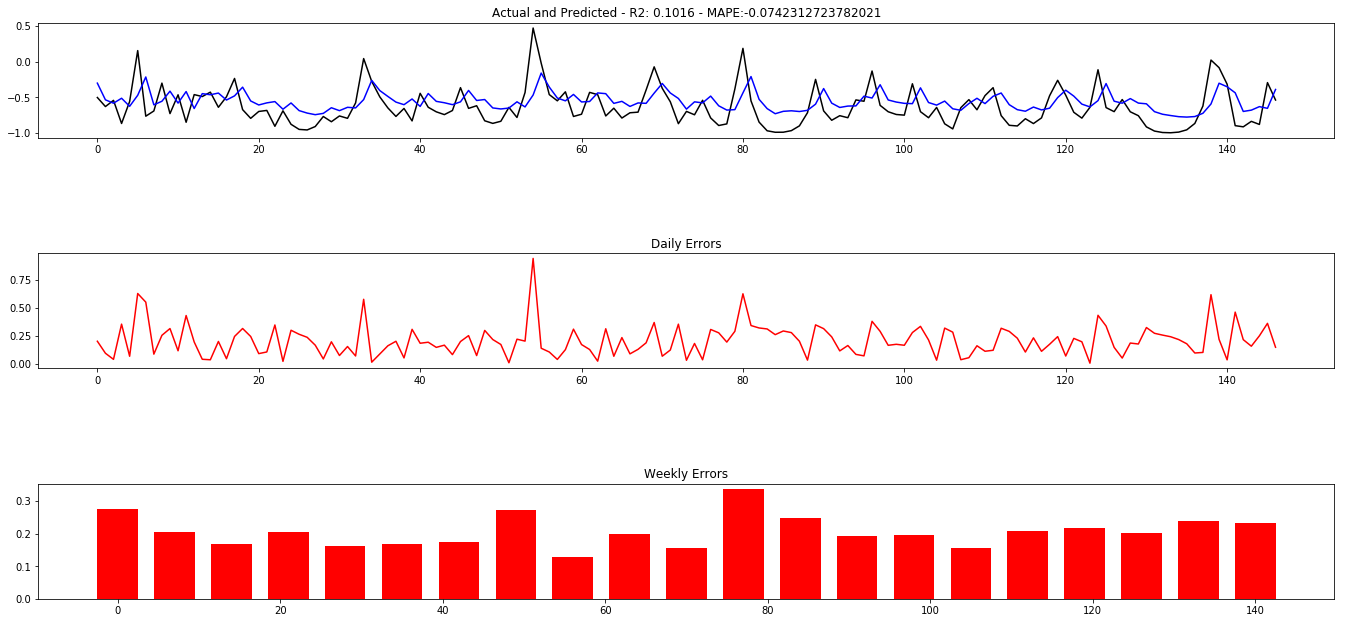

In [64]:
 plot_prediction(Y_val, model.predict(X_val))

# TEST

In [65]:
norm_test_daily_prices = minmax_norm(test_daily_prices, a=-1, b=1)
norm_test_daily_volumes = minmax_norm(test_daily_volumes, a=-1, b=1)

# Not Normalized

In [66]:
#normalized d_list
d_list = [test_daily_volumes, test_daily_prices]

#NOT normalized d_list
#d_list = [weekly_prices, weekly_volumes]

length = len(d_list[0])
step = 1
forecast = 1
windows = [6, 8, 12]

test_data_dict = {}
for window in windows:
    X = []
    Y = []
    for i in range(0, length, step):
        try:
            # Get windowed data
            windowed_features_list = []
            for j in range(len(d_list)):
                windowed_features_list.append(d_list[j][i:i+window])

            # ALWAYS TAKE THE FIRST data 
            y_i = d_list[0][i + window + forecast - 1] # indexing is important.
            x_i = np.column_stack(tuple(windowed_features_list))
        except Exception as e:
            print(e)
            break
        X.append(x_i)
        Y.append(y_i)
    test_data_dict[window] = {'X': np.array(X), 'Y': np.array(Y)}

index 82 is out of bounds for axis 0 with size 82
index 82 is out of bounds for axis 0 with size 82
index 82 is out of bounds for axis 0 with size 82


# Normalized

In [67]:
#normalized d_list
d_list = [norm_test_daily_volumes, norm_test_daily_prices]

#NOT normalized d_list
#d_list = [weekly_prices, weekly_volumes]

length = len(d_list[0])
step = 1
forecast = 1
windows = [6, 8, 12]

norm_test_data_dict = {}
for window in windows:
    X = []
    Y = []
    for i in range(0, length, step):
        try:
            # Get windowed data
            windowed_features_list = []
            for j in range(len(d_list)):
                windowed_features_list.append(d_list[j][i:i+window])

            # ALWAYS TAKE THE FIRST data 
            y_i = d_list[0][i + window + forecast - 1] # indexing is important.
            x_i = np.column_stack(tuple(windowed_features_list))
        except Exception as e:
            print(e)
            break
        X.append(x_i)
        Y.append(y_i)
    norm_test_data_dict[window] = {'X': np.array(X), 'Y': np.array(Y)}

index 82 is out of bounds for axis 0 with size 82
index 82 is out of bounds for axis 0 with size 82
index 82 is out of bounds for axis 0 with size 82


In [68]:
X_test = norm_test_data_dict[w]['X']
#Y_test = test_data_dict[w]['Y']
not_norm_true_values = test_data_dict[w]['Y']

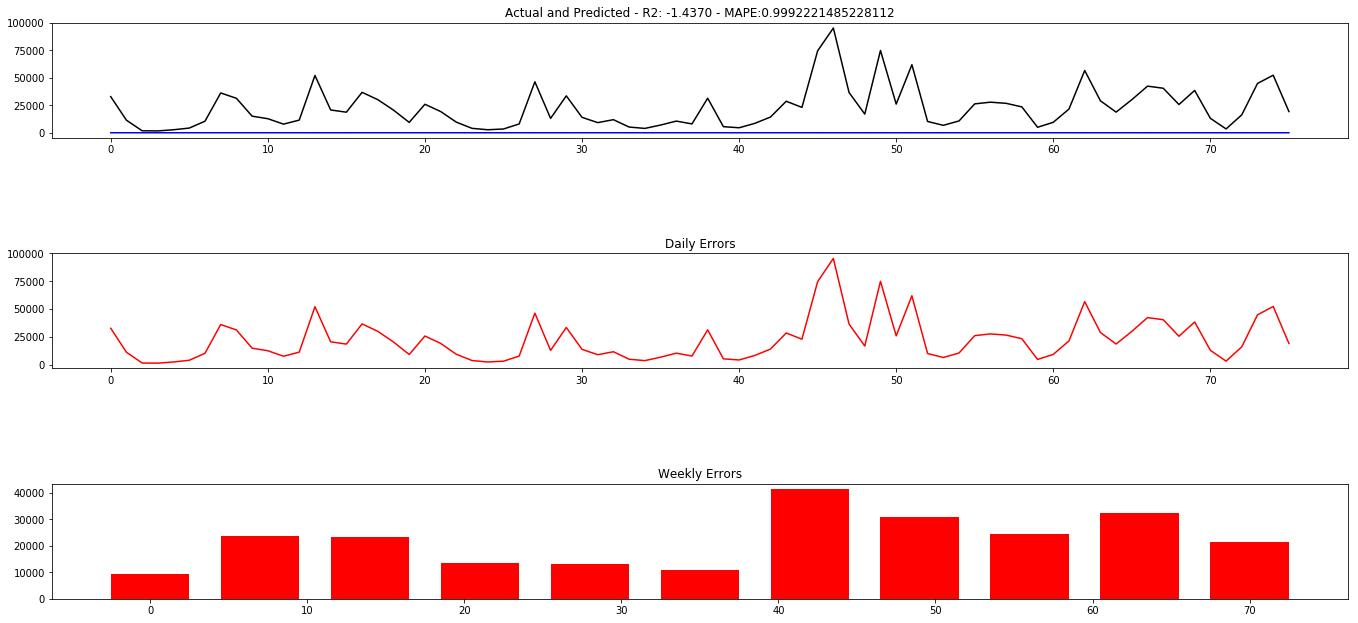

In [69]:
pred_y = model.predict(X_test)
pred_yy = minmax_denorm(test_daily_prices, pred_y, a=-1, b=1)
plot_prediction(not_norm_true_values, pred_yy)

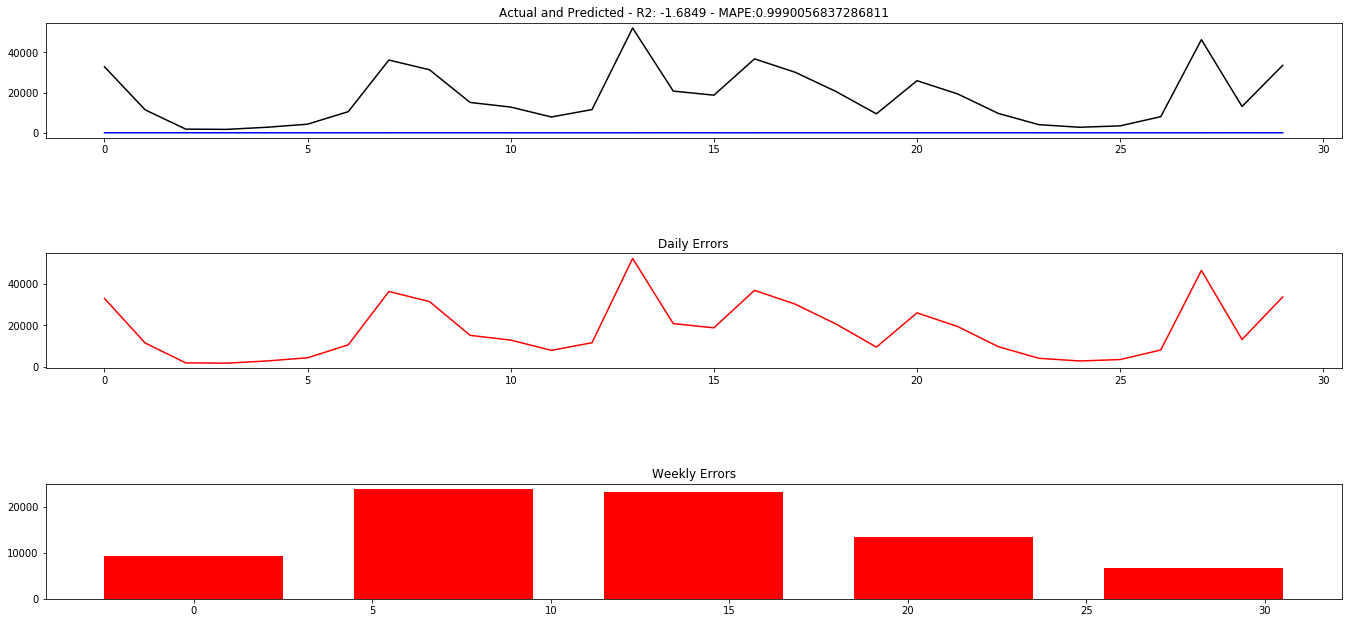

In [70]:
t=0
tp = 30
plot_prediction(not_norm_true_values[t:t+tp], pred_yy[t:t+tp])

# Training with Non-Normalized Data

In [71]:
nX_ = data_dict[w]['X']
nY_ = data_dict[w]['Y']
X_train_, X_val_, Y_train_, Y_val_ = get_train_validation(nX_, nY_)

In [72]:
print('X_train_: '+str(X_train_.shape))
print('X_val_: '+str(X_val_.shape))

X_train_: (584, 6, 2)
X_val_: (147, 6, 2)


In [73]:
print(X_train_[0])
print(Y_train_[0])
print('*'*50)
print(X_train_[1])
print(Y_train_[1])
print('*'*50)

[[1.62244603e+03 5.06204651e+00]
 [4.90568464e+03 5.06204651e+00]
 [1.70635436e+04 4.05010000e+00]
 [4.84539564e+04 3.28664437e+00]
 [6.31609458e+04 3.13252469e+00]
 [4.35303300e+04 3.05356667e+00]]
23340.026252179527
**************************************************
[[4.90568464e+03 5.06204651e+00]
 [1.70635436e+04 4.05010000e+00]
 [4.84539564e+04 3.28664437e+00]
 [6.31609458e+04 3.13252469e+00]
 [4.35303300e+04 3.05356667e+00]
 [2.33400263e+04 3.34217950e+00]]
18869.53568014524
**************************************************


In [74]:
learning_rate=0.0001
epochs=1000
verbose=1
model_dir = 'models/'
model_save_name = model_dir + 'bidirlstm_multivariate_model_' + CURRENT_SUBSTANCE + '_interpolated_data_quantity_no_norm.h5'
    
#opt_1 = tf.keras.optimizers.Adam(learning_rate)
opt_1 = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
loss_func = tf.keras.losses.mean_squared_error

metrics = []
metrics.append(tf.keras.metrics.mean_absolute_error)
metrics.append(tf.keras.metrics.mean_squared_error)
metrics.append(tf.keras.metrics.mean_absolute_percentage_error)

print("Model will be saved at: " + model_save_name)
model.compile(optimizer=opt_1, 
                  loss=loss_func, 
                  metrics=metrics)
    
callbacks = []
cp = tf.keras.callbacks.ModelCheckpoint(filepath=model_save_name, verbose=1, save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
    
callbacks.append(cp)
callbacks.append(early_stop)

Model will be saved at: models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5


In [75]:
history = model.fit(X_train_, Y_train_, epochs = epochs,  batch_size = batch_size, 
                    verbose=verbose, validation_data=(X_val_, Y_val_), validation_split=0.8, callbacks=callbacks)

Train on 584 samples, validate on 147 samples
Epoch 1/1000
512/584 [=========================>....] - ETA: 0s - loss: 945330516.0000 - mean_absolute_error: 24583.8463 - mean_squared_error: 945330516.0000 - mean_absolute_percentage_error: 100.0084
Epoch 00001: val_loss improved from inf to 529952608.00000, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 3s 5ms/step - loss: 917901343.5616 - mean_absolute_error: 24114.2297 - mean_squared_error: 917901343.5616 - mean_absolute_percentage_error: 100.0087 - val_loss: 529952608.0000 - val_mean_absolute_error: 18806.7070 - val_mean_squared_error: 529952608.0000 - val_mean_absolute_percentage_error: 100.0121
Epoch 2/1000
512/584 [=========================>....] - ETA: 0s - loss: 913222324.0000 - mean_absolute_error: 23956.7897 - mean_squared_error: 913222324.0000 - mean_absolute_percentage_error: 100.0085
Epoch 00002: val_loss improved from 529952608

584/584 [==============================] - 1s 936us/step - loss: 917886542.9041 - mean_absolute_error: 24113.9239 - mean_squared_error: 917886542.9041 - mean_absolute_percentage_error: 100.0059 - val_loss: 529941086.2585 - val_mean_absolute_error: 18806.3997 - val_mean_squared_error: 529941086.2585 - val_mean_absolute_percentage_error: 100.0082
Epoch 13/1000
576/584 [============================>.] - ETA: 0s - loss: 918991304.8889 - mean_absolute_error: 24076.3992 - mean_squared_error: 918991304.8889 - mean_absolute_percentage_error: 100.0057
Epoch 00013: val_loss improved from 529941086.25850 to 529940077.27891, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 1s 873us/step - loss: 917885216.4384 - mean_absolute_error: 24113.8961 - mean_squared_error: 917885216.4384 - mean_absolute_percentage_error: 100.0057 - val_loss: 529940077.2789 - val_mean_absolute_error: 18806.3718 - val_mean_squared

Epoch 24/1000
544/584 [==========================>...] - ETA: 0s - loss: 927041784.4706 - mean_absolute_error: 24254.3305 - mean_squared_error: 927041784.4706 - mean_absolute_percentage_error: 100.0030
Epoch 00024: val_loss improved from 529929550.58503 to 529928517.87755, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 1s 985us/step - loss: 917870427.1781 - mean_absolute_error: 24113.5896 - mean_squared_error: 917870427.1781 - mean_absolute_percentage_error: 100.0030 - val_loss: 529928517.8776 - val_mean_absolute_error: 18806.0665 - val_mean_squared_error: 529928517.8776 - val_mean_absolute_percentage_error: 100.0040
Epoch 25/1000
576/584 [============================>.] - ETA: 0s - loss: 921051009.7778 - mean_absolute_error: 24141.3396 - mean_squared_error: 921051009.7778 - mean_absolute_percentage_error: 100.0027
Epoch 00025: val_loss improved from 529928517.87755 to 529927486.69388, sav

Epoch 36/1000
544/584 [==========================>...] - ETA: 0s - loss: 929484894.1176 - mean_absolute_error: 24178.2984 - mean_squared_error: 929484894.1176 - mean_absolute_percentage_error: 100.0000 
Epoch 00036: val_loss improved from 529917037.93197 to 529915971.91837, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 845us/step - loss: 917854403.5068 - mean_absolute_error: 24113.2568 - mean_squared_error: 917854403.5068 - mean_absolute_percentage_error: 100.0000 - val_loss: 529915971.9184 - val_mean_absolute_error: 18805.7330 - val_mean_squared_error: 529915971.9184 - val_mean_absolute_percentage_error: 99.9998
Epoch 37/1000
512/584 [=========================>....] - ETA: 0s - loss: 901636456.0000 - mean_absolute_error: 23973.5938 - mean_squared_error: 901636456.0000 - mean_absolute_percentage_error: 99.9998
Epoch 00037: val_loss improved from 529915971.91837 to 529914950.31293, savi

Epoch 00047: val_loss improved from 529905656.59864 to 529904562.72109, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 1s 929us/step - loss: 917839736.9863 - mean_absolute_error: 24112.9524 - mean_squared_error: 917839736.9863 - mean_absolute_percentage_error: 99.9973 - val_loss: 529904562.7211 - val_mean_absolute_error: 18805.4298 - val_mean_squared_error: 529904562.7211 - val_mean_absolute_percentage_error: 99.9960
Epoch 48/1000
576/584 [============================>.] - ETA: 0s - loss: 926366440.8889 - mean_absolute_error: 24240.1213 - mean_squared_error: 926366440.8889 - mean_absolute_percentage_error: 99.9971
Epoch 00048: val_loss improved from 529904562.72109 to 529903531.53741, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 1s 910us/step - loss: 917838388.6027 - mean_absolute_error: 241

Epoch 59/1000
512/584 [=========================>....] - ETA: 0s - loss: 926927068.0000 - mean_absolute_error: 24360.3534 - mean_squared_error: 926927068.0000 - mean_absolute_percentage_error: 99.9947
Epoch 00059: val_loss improved from 529893148.08163 to 529892096.00000, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 842us/step - loss: 917823731.2877 - mean_absolute_error: 24112.6213 - mean_squared_error: 917823731.2877 - mean_absolute_percentage_error: 99.9943 - val_loss: 529892096.0000 - val_mean_absolute_error: 18805.0978 - val_mean_squared_error: 529892096.0000 - val_mean_absolute_percentage_error: 99.9918
Epoch 60/1000
576/584 [============================>.] - ETA: 0s - loss: 912764654.2222 - mean_absolute_error: 24018.9758 - mean_squared_error: 912764654.2222 - mean_absolute_percentage_error: 99.9941
Epoch 00060: val_loss improved from 529892096.00000 to 529891057.85034, saving 

Epoch 71/1000
512/584 [=========================>....] - ETA: 0s - loss: 940443036.0000 - mean_absolute_error: 24366.8663 - mean_squared_error: 940443036.0000 - mean_absolute_percentage_error: 99.9915
Epoch 00071: val_loss improved from 529880616.05442 to 529879597.27891, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 823us/step - loss: 917807694.9041 - mean_absolute_error: 24112.2884 - mean_squared_error: 917807694.9041 - mean_absolute_percentage_error: 99.9914 - val_loss: 529879597.2789 - val_mean_absolute_error: 18804.7658 - val_mean_squared_error: 529879597.2789 - val_mean_absolute_percentage_error: 99.9876
Epoch 72/1000
512/584 [=========================>....] - ETA: 0s - loss: 932475168.0000 - mean_absolute_error: 24360.1356 - mean_squared_error: 932475168.0000 - mean_absolute_percentage_error: 99.9914
Epoch 00072: val_loss improved from 529879597.27891 to 529878532.57143, saving 

584/584 [==============================] - 1s 885us/step - loss: 917793008.2192 - mean_absolute_error: 24111.9839 - mean_squared_error: 917793008.2192 - mean_absolute_percentage_error: 99.9887 - val_loss: 529868125.6054 - val_mean_absolute_error: 18804.4609 - val_mean_squared_error: 529868125.6054 - val_mean_absolute_percentage_error: 99.9837
Epoch 83/1000
512/584 [=========================>....] - ETA: 0s - loss: 914952176.0000 - mean_absolute_error: 23920.9036 - mean_squared_error: 914952176.0000 - mean_absolute_percentage_error: 99.9881
Epoch 00083: val_loss improved from 529868125.60544 to 529867070.69388, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 816us/step - loss: 917791656.3288 - mean_absolute_error: 24111.9562 - mean_squared_error: 917791656.3288 - mean_absolute_percentage_error: 99.9884 - val_loss: 529867070.6939 - val_mean_absolute_error: 18804.4333 - val_mean_squared_err

Epoch 94/1000
512/584 [=========================>....] - ETA: 0s - loss: 939259200.0000 - mean_absolute_error: 24404.3436 - mean_squared_error: 939259200.0000 - mean_absolute_percentage_error: 99.9855
Epoch 00094: val_loss improved from 529856616.27211 to 529855586.39456, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 823us/step - loss: 917776905.6438 - mean_absolute_error: 24111.6504 - mean_squared_error: 917776905.6438 - mean_absolute_percentage_error: 99.9857 - val_loss: 529855586.3946 - val_mean_absolute_error: 18804.1271 - val_mean_squared_error: 529855586.3946 - val_mean_absolute_percentage_error: 99.9795
Epoch 95/1000
512/584 [=========================>....] - ETA: 0s - loss: 913049220.0000 - mean_absolute_error: 24124.3201 - mean_squared_error: 913049220.0000 - mean_absolute_percentage_error: 99.9853
Epoch 00095: val_loss improved from 529855586.39456 to 529854569.14286, saving 

Epoch 106/1000
512/584 [=========================>....] - ETA: 0s - loss: 877444162.0000 - mean_absolute_error: 23664.7323 - mean_squared_error: 877444162.0000 - mean_absolute_percentage_error: 99.9824
Epoch 00106: val_loss improved from 529844138.44898 to 529843101.60544, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 823us/step - loss: 917760864.4384 - mean_absolute_error: 24111.3181 - mean_squared_error: 917760864.4384 - mean_absolute_percentage_error: 99.9828 - val_loss: 529843101.6054 - val_mean_absolute_error: 18803.7946 - val_mean_squared_error: 529843101.6054 - val_mean_absolute_percentage_error: 99.9753
Epoch 107/1000
512/584 [=========================>....] - ETA: 0s - loss: 921768256.0000 - mean_absolute_error: 24056.7206 - mean_squared_error: 921768256.0000 - mean_absolute_percentage_error: 99.9821
Epoch 00107: val_loss improved from 529843101.60544 to 529842036.89796, savin

Epoch 118/1000
512/584 [=========================>....] - ETA: 0s - loss: 903113790.0000 - mean_absolute_error: 23977.6194 - mean_squared_error: 903113790.0000 - mean_absolute_percentage_error: 99.9797
Epoch 00118: val_loss improved from 529831666.06803 to 529830613.98639, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 801us/step - loss: 917744858.3014 - mean_absolute_error: 24110.9858 - mean_squared_error: 917744858.3014 - mean_absolute_percentage_error: 99.9798 - val_loss: 529830613.9864 - val_mean_absolute_error: 18803.4617 - val_mean_squared_error: 529830613.9864 - val_mean_absolute_percentage_error: 99.9711
Epoch 119/1000
512/584 [=========================>....] - ETA: 0s - loss: 912181136.0000 - mean_absolute_error: 24034.7030 - mean_squared_error: 912181136.0000 - mean_absolute_percentage_error: 99.9791
Epoch 00119: val_loss improved from 529830613.98639 to 529829531.21088, savin

584/584 [==============================] - 0s 821us/step - loss: 917730214.5753 - mean_absolute_error: 24110.6818 - mean_squared_error: 917730214.5753 - mean_absolute_percentage_error: 99.9771 - val_loss: 529819160.3810 - val_mean_absolute_error: 18803.1583 - val_mean_squared_error: 529819160.3810 - val_mean_absolute_percentage_error: 99.9672
Epoch 130/1000
512/584 [=========================>....] - ETA: 0s - loss: 892859816.0000 - mean_absolute_error: 23765.5870 - mean_squared_error: 892859816.0000 - mean_absolute_percentage_error: 99.9765
Epoch 00130: val_loss improved from 529819160.38095 to 529818122.23129, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 811us/step - loss: 917728865.3151 - mean_absolute_error: 24110.6542 - mean_squared_error: 917728865.3151 - mean_absolute_percentage_error: 99.9768 - val_loss: 529818122.2313 - val_mean_absolute_error: 18803.1314 - val_mean_squared_er

Epoch 141/1000
512/584 [=========================>....] - ETA: 0s - loss: 889174330.0000 - mean_absolute_error: 23788.5948 - mean_squared_error: 889174330.0000 - mean_absolute_percentage_error: 99.9734
Epoch 00141: val_loss improved from 529807748.57143 to 529806739.59184, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 798us/step - loss: 917714267.6164 - mean_absolute_error: 24110.3515 - mean_squared_error: 917714267.6164 - mean_absolute_percentage_error: 99.9741 - val_loss: 529806739.5918 - val_mean_absolute_error: 18802.8283 - val_mean_squared_error: 529806739.5918 - val_mean_absolute_percentage_error: 99.9631
Epoch 142/1000
512/584 [=========================>....] - ETA: 0s - loss: 947435676.0000 - mean_absolute_error: 24573.1002 - mean_squared_error: 947435676.0000 - mean_absolute_percentage_error: 99.9741
Epoch 00142: val_loss improved from 529806739.59184 to 529805708.40816, savin

Epoch 00152: val_loss improved from 529796386.82993 to 529795308.19048, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 1s 944us/step - loss: 917699641.8630 - mean_absolute_error: 24110.0479 - mean_squared_error: 917699641.8630 - mean_absolute_percentage_error: 99.9714 - val_loss: 529795308.1905 - val_mean_absolute_error: 18802.5236 - val_mean_squared_error: 529795308.1905 - val_mean_absolute_percentage_error: 99.9592
Epoch 153/1000
512/584 [=========================>....] - ETA: 0s - loss: 914290780.0000 - mean_absolute_error: 24123.3262 - mean_squared_error: 914290780.0000 - mean_absolute_percentage_error: 99.9709
Epoch 00153: val_loss improved from 529795308.19048 to 529794313.14286, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 820us/step - loss: 917698288.2192 - mean_absolute_error: 24

Epoch 164/1000
512/584 [=========================>....] - ETA: 0s - loss: 914073136.0000 - mean_absolute_error: 23877.1398 - mean_squared_error: 914073136.0000 - mean_absolute_percentage_error: 99.9676
Epoch 00164: val_loss improved from 529783779.48299 to 529782749.60544, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 798us/step - loss: 917683512.1096 - mean_absolute_error: 24109.7133 - mean_squared_error: 917683512.1096 - mean_absolute_percentage_error: 99.9685 - val_loss: 529782749.6054 - val_mean_absolute_error: 18802.1896 - val_mean_squared_error: 529782749.6054 - val_mean_absolute_percentage_error: 99.9550
Epoch 165/1000
512/584 [=========================>....] - ETA: 0s - loss: 894326262.0000 - mean_absolute_error: 23714.1963 - mean_squared_error: 894326262.0000 - mean_absolute_percentage_error: 99.9679
Epoch 00165: val_loss improved from 529782749.60544 to 529781698.82993, savin

512/584 [=========================>....] - ETA: 0s - loss: 918465276.0000 - mean_absolute_error: 24068.6360 - mean_squared_error: 918465276.0000 - mean_absolute_percentage_error: 99.9652
Epoch 00175: val_loss improved from 529772356.57143 to 529771323.86395, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 792us/step - loss: 917668876.2740 - mean_absolute_error: 24109.4099 - mean_squared_error: 917668876.2740 - mean_absolute_percentage_error: 99.9658 - val_loss: 529771323.8639 - val_mean_absolute_error: 18801.8869 - val_mean_squared_error: 529771323.8639 - val_mean_absolute_percentage_error: 99.9511
Epoch 176/1000
512/584 [=========================>....] - ETA: 0s - loss: 871615236.9231 - mean_absolute_error: 23581.0651 - mean_squared_error: 871615236.9231 - mean_absolute_percentage_error: 99.96 - ETA: 0s - loss: 904732096.0000 - mean_absolute_error: 23843.7928 - mean_squared_error: 90473

512/584 [=========================>....] - ETA: 0s - loss: 900075950.0000 - mean_absolute_error: 23745.8634 - mean_squared_error: 900075950.0000 - mean_absolute_percentage_error: 99.9615
Epoch 00186: val_loss improved from 529760932.13605 to 529759934.25850, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 823us/step - loss: 917654229.9178 - mean_absolute_error: 24109.1068 - mean_squared_error: 917654229.9178 - mean_absolute_percentage_error: 99.9631 - val_loss: 529759934.2585 - val_mean_absolute_error: 18801.5823 - val_mean_squared_error: 529759934.2585 - val_mean_absolute_percentage_error: 99.9473
Epoch 187/1000
512/584 [=========================>....] - ETA: 0s - loss: 934183180.0000 - mean_absolute_error: 24197.4392 - mean_squared_error: 934183180.0000 - mean_absolute_percentage_error: 99.9627
Epoch 00187: val_loss improved from 529759934.25850 to 529758847.34694, saving model to mode

Epoch 198/1000
512/584 [=========================>....] - ETA: 0s - loss: 941126928.0000 - mean_absolute_error: 24345.8778 - mean_squared_error: 941126928.0000 - mean_absolute_percentage_error: 99.9592
Epoch 00198: val_loss improved from 529748384.65306 to 529747325.60544, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 786us/step - loss: 917638105.4247 - mean_absolute_error: 24108.7723 - mean_squared_error: 917638105.4247 - mean_absolute_percentage_error: 99.9601 - val_loss: 529747325.6054 - val_mean_absolute_error: 18801.2485 - val_mean_squared_error: 529747325.6054 - val_mean_absolute_percentage_error: 99.9431
Epoch 199/1000
544/584 [==========================>...] - ETA: 0s - loss: 906109312.0000 - mean_absolute_error: 23838.9935 - mean_squared_error: 906109312.0000 - mean_absolute_percentage_error: 99.9592
Epoch 00199: val_loss improved from 529747325.60544 to 529746295.72789, savin

Epoch 210/1000
544/584 [==========================>...] - ETA: 0s - loss: 911343120.9412 - mean_absolute_error: 24144.1059 - mean_squared_error: 911343120.9412 - mean_absolute_percentage_error: 99.9588
Epoch 00210: val_loss improved from 529735876.13605 to 529734837.98639, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 1s 881us/step - loss: 917622075.6164 - mean_absolute_error: 24108.4392 - mean_squared_error: 917622075.6164 - mean_absolute_percentage_error: 99.9571 - val_loss: 529734837.9864 - val_mean_absolute_error: 18800.9147 - val_mean_squared_error: 529734837.9864 - val_mean_absolute_percentage_error: 99.9389
Epoch 211/1000
576/584 [============================>.] - ETA: 0s - loss: 911749162.6667 - mean_absolute_error: 24009.7625 - mean_squared_error: 911749162.6667 - mean_absolute_percentage_error: 99.9566
Epoch 00211: val_loss improved from 529734837.98639 to 529733780.24490, savin

Epoch 222/1000
512/584 [=========================>....] - ETA: 0s - loss: 898138088.0000 - mean_absolute_error: 24032.9330 - mean_squared_error: 898138088.0000 - mean_absolute_percentage_error: 99.9551
Epoch 00222: val_loss improved from 529723420.51701 to 529722361.46939, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 1s 881us/step - loss: 917606098.4110 - mean_absolute_error: 24108.1078 - mean_squared_error: 917606098.4110 - mean_absolute_percentage_error: 99.9542 - val_loss: 529722361.4694 - val_mean_absolute_error: 18800.5847 - val_mean_squared_error: 529722361.4694 - val_mean_absolute_percentage_error: 99.9347
Epoch 223/1000
576/584 [============================>.] - ETA: 0s - loss: 918725205.3333 - mean_absolute_error: 24095.5307 - mean_squared_error: 918725205.3333 - mean_absolute_percentage_error: 99.9538
Epoch 00223: val_loss improved from 529722361.46939 to 529721331.59184, savin

584/584 [==============================] - 1s 1ms/step - loss: 917591488.8767 - mean_absolute_error: 24107.8048 - mean_squared_error: 917591488.8767 - mean_absolute_percentage_error: 99.9515 - val_loss: 529710956.6259 - val_mean_absolute_error: 18800.2815 - val_mean_squared_error: 529710956.6259 - val_mean_absolute_percentage_error: 99.9308
Epoch 234/1000
576/584 [============================>.] - ETA: 0s - loss: 922796849.7778 - mean_absolute_error: 24150.0511 - mean_squared_error: 922796849.7778 - mean_absolute_percentage_error: 99.9510
Epoch 00234: val_loss improved from 529710956.62585 to 529709912.81633, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 1s 1ms/step - loss: 917590140.4932 - mean_absolute_error: 24107.7773 - mean_squared_error: 917590140.4932 - mean_absolute_percentage_error: 99.9512 - val_loss: 529709912.8163 - val_mean_absolute_error: 18800.2540 - val_mean_squared_error:

Epoch 245/1000
512/584 [=========================>....] - ETA: 0s - loss: 941587826.0000 - mean_absolute_error: 24369.8130 - mean_squared_error: 941587826.0000 - mean_absolute_percentage_error: 99.9482
Epoch 00245: val_loss improved from 529699539.15646 to 529698473.14286, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 811us/step - loss: 917575456.4384 - mean_absolute_error: 24107.4729 - mean_squared_error: 917575456.4384 - mean_absolute_percentage_error: 99.9485 - val_loss: 529698473.1429 - val_mean_absolute_error: 18799.9494 - val_mean_squared_error: 529698473.1429 - val_mean_absolute_percentage_error: 99.9266
Epoch 246/1000
512/584 [=========================>....] - ETA: 0s - loss: 881822572.0000 - mean_absolute_error: 23670.6589 - mean_squared_error: 881822572.0000 - mean_absolute_percentage_error: 99.9467
Epoch 00246: val_loss improved from 529698473.14286 to 529697455.89116, savin

584/584 [==============================] - 0s 830us/step - loss: 917560758.3562 - mean_absolute_error: 24107.1677 - mean_squared_error: 917560758.3562 - mean_absolute_percentage_error: 99.9458 - val_loss: 529687044.5714 - val_mean_absolute_error: 18799.6445 - val_mean_squared_error: 529687044.5714 - val_mean_absolute_percentage_error: 99.9228
Epoch 257/1000
512/584 [=========================>....] - ETA: 0s - loss: 905770744.0000 - mean_absolute_error: 23886.2958 - mean_squared_error: 905770744.0000 - mean_absolute_percentage_error: 99.9439
Epoch 00257: val_loss improved from 529687044.57143 to 529685964.62585, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 798us/step - loss: 917559402.5205 - mean_absolute_error: 24107.1399 - mean_squared_error: 917559402.5205 - mean_absolute_percentage_error: 99.9456 - val_loss: 529685964.6259 - val_mean_absolute_error: 18799.6173 - val_mean_squared_er

Epoch 268/1000
512/584 [=========================>....] - ETA: 0s - loss: 918351456.0000 - mean_absolute_error: 24093.5424 - mean_squared_error: 918351456.0000 - mean_absolute_percentage_error: 99.9427
Epoch 00268: val_loss improved from 529675526.96599 to 529674497.08844, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 806us/step - loss: 917544696.9863 - mean_absolute_error: 24106.8345 - mean_squared_error: 917544696.9863 - mean_absolute_percentage_error: 99.9428 - val_loss: 529674497.0884 - val_mean_absolute_error: 18799.3112 - val_mean_squared_error: 529674497.0884 - val_mean_absolute_percentage_error: 99.9186
Epoch 269/1000
512/584 [=========================>....] - ETA: 0s - loss: 891983804.0000 - mean_absolute_error: 23987.0101 - mean_squared_error: 891983804.0000 - mean_absolute_percentage_error: 99.9424
Epoch 00269: val_loss improved from 529674497.08844 to 529673467.21088, savin

584/584 [==============================] - 0s 832us/step - loss: 917529998.0274 - mean_absolute_error: 24106.5302 - mean_squared_error: 917529998.0274 - mean_absolute_percentage_error: 99.9401 - val_loss: 529663039.3469 - val_mean_absolute_error: 18799.0064 - val_mean_squared_error: 529663039.3469 - val_mean_absolute_percentage_error: 99.9147
Epoch 280/1000
512/584 [=========================>....] - ETA: 0s - loss: 900095176.0000 - mean_absolute_error: 23717.3890 - mean_squared_error: 900095176.0000 - mean_absolute_percentage_error: 99.9375
Epoch 00280: val_loss improved from 529663039.34694 to 529662009.46939, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 803us/step - loss: 917528663.6712 - mean_absolute_error: 24106.5024 - mean_squared_error: 917528663.6712 - mean_absolute_percentage_error: 99.9399 - val_loss: 529662009.4694 - val_mean_absolute_error: 18798.9788 - val_mean_squared_er

Epoch 291/1000
512/584 [=========================>....] - ETA: 0s - loss: 881699964.0000 - mean_absolute_error: 23593.4515 - mean_squared_error: 881699964.0000 - mean_absolute_percentage_error: 99.9364
Epoch 00291: val_loss improved from 529651592.70748 to 529650555.86395, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 815us/step - loss: 917514005.0411 - mean_absolute_error: 24106.1985 - mean_squared_error: 917514005.0411 - mean_absolute_percentage_error: 99.9372 - val_loss: 529650555.8639 - val_mean_absolute_error: 18798.6754 - val_mean_squared_error: 529650555.8639 - val_mean_absolute_percentage_error: 99.9105
Epoch 292/1000
512/584 [=========================>....] - ETA: 0s - loss: 830521448.0000 - mean_absolute_error: 23072.4838 - mean_squared_error: 830521448.0000 - mean_absolute_percentage_error: 99.9341
Epoch 00292: val_loss improved from 529650555.86395 to 529649510.74830, savin

584/584 [==============================] - 1s 859us/step - loss: 917499328.8767 - mean_absolute_error: 24105.8939 - mean_squared_error: 917499328.8767 - mean_absolute_percentage_error: 99.9345 - val_loss: 529639095.2925 - val_mean_absolute_error: 18798.3708 - val_mean_squared_error: 529639095.2925 - val_mean_absolute_percentage_error: 99.9067
Epoch 303/1000
512/584 [=========================>....] - ETA: 0s - loss: 908484192.0000 - mean_absolute_error: 24059.6589 - mean_squared_error: 908484192.0000 - mean_absolute_percentage_error: 99.9345
Epoch 00303: val_loss improved from 529639095.29252 to 529638057.14286, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 794us/step - loss: 917497997.1507 - mean_absolute_error: 24105.8661 - mean_squared_error: 917497997.1507 - mean_absolute_percentage_error: 99.9342 - val_loss: 529638057.1429 - val_mean_absolute_error: 18798.3433 - val_mean_squared_er

Epoch 314/1000
512/584 [=========================>....] - ETA: 0s - loss: 948566224.0000 - mean_absolute_error: 24559.6411 - mean_squared_error: 948566224.0000 - mean_absolute_percentage_error: 99.9320
Epoch 00314: val_loss improved from 529627708.51701 to 529626695.40136, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 818us/step - loss: 917483374.4658 - mean_absolute_error: 24105.5620 - mean_squared_error: 917483374.4658 - mean_absolute_percentage_error: 99.9315 - val_loss: 529626695.4014 - val_mean_absolute_error: 18798.0391 - val_mean_squared_error: 529626695.4014 - val_mean_absolute_percentage_error: 99.9025
Epoch 315/1000
512/584 [=========================>....] - ETA: 0s - loss: 918362002.0000 - mean_absolute_error: 24032.3502 - mean_squared_error: 918362002.0000 - mean_absolute_percentage_error: 99.9296
Epoch 00315: val_loss improved from 529626695.40136 to 529625622.42177, savin

584/584 [==============================] - 0s 825us/step - loss: 917468728.1096 - mean_absolute_error: 24105.2584 - mean_squared_error: 917468728.1096 - mean_absolute_percentage_error: 99.9288 - val_loss: 529615243.1020 - val_mean_absolute_error: 18797.7345 - val_mean_squared_error: 529615243.1020 - val_mean_absolute_percentage_error: 99.8986
Epoch 326/1000
512/584 [=========================>....] - ETA: 0s - loss: 957200008.0000 - mean_absolute_error: 24604.9910 - mean_squared_error: 957200008.0000 - mean_absolute_percentage_error: 99.9288
Epoch 00326: val_loss improved from 529615243.10204 to 529614174.25850, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 799us/step - loss: 917467360.4384 - mean_absolute_error: 24105.2304 - mean_squared_error: 917467360.4384 - mean_absolute_percentage_error: 99.9285 - val_loss: 529614174.2585 - val_mean_absolute_error: 18797.7070 - val_mean_squared_er

Epoch 337/1000
512/584 [=========================>....] - ETA: 0s - loss: 920081736.0000 - mean_absolute_error: 24161.4666 - mean_squared_error: 920081736.0000 - mean_absolute_percentage_error: 99.9243
Epoch 00337: val_loss improved from 529603827.15646 to 529602812.51701, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 811us/step - loss: 917452726.3562 - mean_absolute_error: 24104.9272 - mean_squared_error: 917452726.3562 - mean_absolute_percentage_error: 99.9259 - val_loss: 529602812.5170 - val_mean_absolute_error: 18797.4030 - val_mean_squared_error: 529602812.5170 - val_mean_absolute_percentage_error: 99.8944
Epoch 338/1000
512/584 [=========================>....] - ETA: 0s - loss: 923663008.0000 - mean_absolute_error: 24067.1156 - mean_squared_error: 923663008.0000 - mean_absolute_percentage_error: 99.9250
Epoch 00338: val_loss improved from 529602812.51701 to 529601738.23129, savin

584/584 [==============================] - 0s 806us/step - loss: 917438076.4932 - mean_absolute_error: 24104.6226 - mean_squared_error: 917438076.4932 - mean_absolute_percentage_error: 99.9231 - val_loss: 529591343.6735 - val_mean_absolute_error: 18797.0985 - val_mean_squared_error: 529591343.6735 - val_mean_absolute_percentage_error: 99.8906
Epoch 349/1000
512/584 [=========================>....] - ETA: 0s - loss: 935354064.0000 - mean_absolute_error: 24280.9640 - mean_squared_error: 935354064.0000 - mean_absolute_percentage_error: 99.9273
Epoch 00349: val_loss improved from 529591343.67347 to 529590284.62585, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 808us/step - loss: 917436703.5616 - mean_absolute_error: 24104.5946 - mean_squared_error: 917436703.5616 - mean_absolute_percentage_error: 99.9229 - val_loss: 529590284.6259 - val_mean_absolute_error: 18797.0706 - val_mean_squared_er

Epoch 360/1000
512/584 [=========================>....] - ETA: 0s - loss: 888935758.0000 - mean_absolute_error: 23778.8390 - mean_squared_error: 888935758.0000 - mean_absolute_percentage_error: 99.9237
Epoch 00360: val_loss improved from 529579885.93197 to 529578849.08844, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 818us/step - loss: 917422006.3562 - mean_absolute_error: 24104.2903 - mean_squared_error: 917422006.3562 - mean_absolute_percentage_error: 99.9202 - val_loss: 529578849.0884 - val_mean_absolute_error: 18796.7663 - val_mean_squared_error: 529578849.0884 - val_mean_absolute_percentage_error: 99.8864
Epoch 361/1000
512/584 [=========================>....] - ETA: 0s - loss: 917196312.0000 - mean_absolute_error: 24096.3838 - mean_squared_error: 917196312.0000 - mean_absolute_percentage_error: 99.9195
Epoch 00361: val_loss improved from 529578849.08844 to 529577801.14286, savin

Epoch 372/1000
576/584 [============================>.] - ETA: 0s - loss: 926268295.1111 - mean_absolute_error: 24249.4643 - mean_squared_error: 926268295.1111 - mean_absolute_percentage_error: 99.9177
Epoch 00372: val_loss improved from 529567360.65306 to 529566336.43537, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 1s 859us/step - loss: 917405999.3425 - mean_absolute_error: 24103.9576 - mean_squared_error: 917405999.3425 - mean_absolute_percentage_error: 99.9172 - val_loss: 529566336.4354 - val_mean_absolute_error: 18796.4337 - val_mean_squared_error: 529566336.4354 - val_mean_absolute_percentage_error: 99.8822
Epoch 373/1000
512/584 [=========================>....] - ETA: 0s - loss: 892115968.0000 - mean_absolute_error: 23803.6609 - mean_squared_error: 892115968.0000 - mean_absolute_percentage_error: 99.9164
Epoch 00373: val_loss improved from 529566336.43537 to 529565306.55782, savin

584/584 [==============================] - 1s 2ms/step - loss: 917391398.5753 - mean_absolute_error: 24103.6559 - mean_squared_error: 917391398.5753 - mean_absolute_percentage_error: 99.9145 - val_loss: 529554974.6939 - val_mean_absolute_error: 18796.1328 - val_mean_squared_error: 529554974.6939 - val_mean_absolute_percentage_error: 99.8783
Epoch 384/1000
544/584 [==========================>...] - ETA: 0s - loss: 910784504.4706 - mean_absolute_error: 23960.2958 - mean_squared_error: 910784504.4706 - mean_absolute_percentage_error: 99.9122
Epoch 00384: val_loss improved from 529554974.69388 to 529553930.88435, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 1s 2ms/step - loss: 917390123.3973 - mean_absolute_error: 24103.6277 - mean_squared_error: 917390123.3973 - mean_absolute_percentage_error: 99.9143 - val_loss: 529553930.8844 - val_mean_absolute_error: 18796.1051 - val_mean_squared_error:

Epoch 395/1000
512/584 [=========================>....] - ETA: 0s - loss: 891990960.0000 - mean_absolute_error: 23719.9209 - mean_squared_error: 891990960.0000 - mean_absolute_percentage_error: 99.9093
Epoch 00395: val_loss improved from 529543503.02041 to 529542533.00680, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 818us/step - loss: 917375440.6575 - mean_absolute_error: 24103.3235 - mean_squared_error: 917375440.6575 - mean_absolute_percentage_error: 99.9116 - val_loss: 529542533.0068 - val_mean_absolute_error: 18795.8008 - val_mean_squared_error: 529542533.0068 - val_mean_absolute_percentage_error: 99.8742
Epoch 396/1000
576/584 [============================>.] - ETA: 0s - loss: 917209312.0000 - mean_absolute_error: 24058.2440 - mean_squared_error: 917209312.0000 - mean_absolute_percentage_error: 99.9111
Epoch 00396: val_loss improved from 529542533.00680 to 529541433.46939, savin

Epoch 407/1000
512/584 [=========================>....] - ETA: 0s - loss: 916561268.0000 - mean_absolute_error: 24026.3290 - mean_squared_error: 916561268.0000 - mean_absolute_percentage_error: 99.9071
Epoch 00407: val_loss improved from 529531076.57143 to 529530038.42177, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 805us/step - loss: 917359461.2603 - mean_absolute_error: 24102.9921 - mean_squared_error: 917359461.2603 - mean_absolute_percentage_error: 99.9086 - val_loss: 529530038.4218 - val_mean_absolute_error: 18795.4690 - val_mean_squared_error: 529530038.4218 - val_mean_absolute_percentage_error: 99.8700
Epoch 408/1000
512/584 [=========================>....] - ETA: 0s - loss: 887737584.0000 - mean_absolute_error: 23587.3231 - mean_squared_error: 887737584.0000 - mean_absolute_percentage_error: 99.9048
Epoch 00408: val_loss improved from 529530038.42177 to 529529007.23810, savin

Epoch 419/1000
512/584 [=========================>....] - ETA: 0s - loss: 917211456.0000 - mean_absolute_error: 24081.8146 - mean_squared_error: 917211456.0000 - mean_absolute_percentage_error: 99.9052
Epoch 00419: val_loss improved from 529518613.98639 to 529517539.70068, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 805us/step - loss: 917343427.5068 - mean_absolute_error: 24102.6605 - mean_squared_error: 917343427.5068 - mean_absolute_percentage_error: 99.9057 - val_loss: 529517539.7007 - val_mean_absolute_error: 18795.1369 - val_mean_squared_error: 529517539.7007 - val_mean_absolute_percentage_error: 99.8658
Epoch 420/1000
576/584 [============================>.] - ETA: 0s - loss: 920158062.2222 - mean_absolute_error: 24123.7592 - mean_squared_error: 920158062.2222 - mean_absolute_percentage_error: 99.9051
Epoch 00420: val_loss improved from 529517539.70068 to 529516523.75510, savin

Epoch 431/1000
512/584 [=========================>....] - ETA: 0s - loss: 908383032.0000 - mean_absolute_error: 23871.8188 - mean_squared_error: 908383032.0000 - mean_absolute_percentage_error: 99.9007
Epoch 00431: val_loss improved from 529506079.12925 to 529505056.21769, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 818us/step - loss: 917327445.0411 - mean_absolute_error: 24102.3282 - mean_squared_error: 917327445.0411 - mean_absolute_percentage_error: 99.9027 - val_loss: 529505056.2177 - val_mean_absolute_error: 18794.8048 - val_mean_squared_error: 529505056.2177 - val_mean_absolute_percentage_error: 99.8616
Epoch 432/1000
576/584 [============================>.] - ETA: 0s - loss: 921022186.6667 - mean_absolute_error: 24103.1301 - mean_squared_error: 921022186.6667 - mean_absolute_percentage_error: 99.9018
Epoch 00432: val_loss improved from 529505056.21769 to 529504038.96599, savin

Epoch 443/1000
512/584 [=========================>....] - ETA: 0s - loss: 935761132.0000 - mean_absolute_error: 24261.4813 - mean_squared_error: 935761132.0000 - mean_absolute_percentage_error: 99.8997
Epoch 00443: val_loss improved from 529493659.64626 to 529492638.04082, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 809us/step - loss: 917311480.1096 - mean_absolute_error: 24101.9966 - mean_squared_error: 917311480.1096 - mean_absolute_percentage_error: 99.8998 - val_loss: 529492638.0408 - val_mean_absolute_error: 18794.4728 - val_mean_squared_error: 529492638.0408 - val_mean_absolute_percentage_error: 99.8574
Epoch 444/1000
512/584 [=========================>....] - ETA: 0s - loss: 891681624.0000 - mean_absolute_error: 23887.8674 - mean_squared_error: 891681624.0000 - mean_absolute_percentage_error: 99.8980
Epoch 00444: val_loss improved from 529492638.04082 to 529491599.89116, savin

584/584 [==============================] - 0s 818us/step - loss: 917296804.8219 - mean_absolute_error: 24101.6919 - mean_squared_error: 917296804.8219 - mean_absolute_percentage_error: 99.8971 - val_loss: 529481176.1633 - val_mean_absolute_error: 18794.1681 - val_mean_squared_error: 529481176.1633 - val_mean_absolute_percentage_error: 99.8535
Epoch 455/1000
512/584 [=========================>....] - ETA: 0s - loss: 912924336.0000 - mean_absolute_error: 24031.6111 - mean_squared_error: 912924336.0000 - mean_absolute_percentage_error: 99.8958
Epoch 00455: val_loss improved from 529481176.16327 to 529480139.31973, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 802us/step - loss: 917295454.2466 - mean_absolute_error: 24101.6644 - mean_squared_error: 917295454.2466 - mean_absolute_percentage_error: 99.8968 - val_loss: 529480139.3197 - val_mean_absolute_error: 18794.1408 - val_mean_squared_er

Epoch 466/1000
512/584 [=========================>....] - ETA: 0s - loss: 911961632.0000 - mean_absolute_error: 23901.6920 - mean_squared_error: 911961632.0000 - mean_absolute_percentage_error: 99.8906
Epoch 00466: val_loss improved from 529469719.72789 to 529468652.40816, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 794us/step - loss: 917280743.4521 - mean_absolute_error: 24101.3594 - mean_squared_error: 917280743.4521 - mean_absolute_percentage_error: 99.8941 - val_loss: 529468652.4082 - val_mean_absolute_error: 18793.8359 - val_mean_squared_error: 529468652.4082 - val_mean_absolute_percentage_error: 99.8493
Epoch 467/1000
512/584 [=========================>....] - ETA: 0s - loss: 934119816.0000 - mean_absolute_error: 24360.7478 - mean_squared_error: 934119816.0000 - mean_absolute_percentage_error: 99.8952
Epoch 00467: val_loss improved from 529468652.40816 to 529467607.29252, savin

576/584 [============================>.] - ETA: 0s - loss: 921457552.0000 - mean_absolute_error: 24121.8115 - mean_squared_error: 921457552.0000 - mean_absolute_percentage_error: 99.8909
Epoch 00477: val_loss improved from 529458321.85034 to 529457298.93878, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 820us/step - loss: 917266124.2740 - mean_absolute_error: 24101.0561 - mean_squared_error: 917266124.2740 - mean_absolute_percentage_error: 99.8914 - val_loss: 529457298.9388 - val_mean_absolute_error: 18793.5333 - val_mean_squared_error: 529457298.9388 - val_mean_absolute_percentage_error: 99.8455
Epoch 478/1000
512/584 [=========================>....] - ETA: 0s - loss: 910793004.0000 - mean_absolute_error: 24101.0787 - mean_squared_error: 910793004.0000 - mean_absolute_percentage_error: 99.8943
Epoch 00478: val_loss improved from 529457298.93878 to 529456260.78912, saving model to mode

Epoch 489/1000
512/584 [=========================>....] - ETA: 0s - loss: 918552906.0000 - mean_absolute_error: 24155.7484 - mean_squared_error: 918552906.0000 - mean_absolute_percentage_error: 99.8880
Epoch 00489: val_loss improved from 529445834.23129 to 529444821.11565, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 855us/step - loss: 917250161.9726 - mean_absolute_error: 24100.7247 - mean_squared_error: 917250161.9726 - mean_absolute_percentage_error: 99.8884 - val_loss: 529444821.1156 - val_mean_absolute_error: 18793.2017 - val_mean_squared_error: 529444821.1156 - val_mean_absolute_percentage_error: 99.8413
Epoch 490/1000
512/584 [=========================>....] - ETA: 0s - loss: 935276872.0000 - mean_absolute_error: 24313.7719 - mean_squared_error: 935276872.0000 - mean_absolute_percentage_error: 99.8864
Epoch 00490: val_loss improved from 529444821.11565 to 529443791.23810, savin

Epoch 00500: val_loss improved from 529434394.55782 to 529433363.37415, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 851us/step - loss: 917235457.7534 - mean_absolute_error: 24100.4198 - mean_squared_error: 917235457.7534 - mean_absolute_percentage_error: 99.8857 - val_loss: 529433363.3741 - val_mean_absolute_error: 18792.8972 - val_mean_squared_error: 529433363.3741 - val_mean_absolute_percentage_error: 99.8374
Epoch 501/1000
512/584 [=========================>....] - ETA: 0s - loss: 929123292.0000 - mean_absolute_error: 24388.5792 - mean_squared_error: 929123292.0000 - mean_absolute_percentage_error: 99.8851
Epoch 00501: val_loss improved from 529433363.37415 to 529432323.70068, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 848us/step - loss: 917234142.6849 - mean_absolute_error: 24

Epoch 512/1000
512/584 [=========================>....] - ETA: 0s - loss: 955242820.0000 - mean_absolute_error: 24617.6515 - mean_squared_error: 955242820.0000 - mean_absolute_percentage_error: 99.8840
Epoch 00512: val_loss improved from 529421916.73469 to 529420886.85714, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 809us/step - loss: 917219465.2055 - mean_absolute_error: 24100.0875 - mean_squared_error: 917219465.2055 - mean_absolute_percentage_error: 99.8828 - val_loss: 529420886.8571 - val_mean_absolute_error: 18792.5633 - val_mean_squared_error: 529420886.8571 - val_mean_absolute_percentage_error: 99.8332
Epoch 513/1000
512/584 [=========================>....] - ETA: 0s - loss: 943970140.0000 - mean_absolute_error: 24424.2123 - mean_squared_error: 943970140.0000 - mean_absolute_percentage_error: 99.8877
Epoch 00513: val_loss improved from 529420886.85714 to 529419786.01361, savin

Epoch 524/1000
512/584 [=========================>....] - ETA: 0s - loss: 894765968.0000 - mean_absolute_error: 23767.6006 - mean_squared_error: 894765968.0000 - mean_absolute_percentage_error: 99.8766
Epoch 00524: val_loss improved from 529409426.28571 to 529408410.34014, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 809us/step - loss: 917203440.2192 - mean_absolute_error: 24099.7560 - mean_squared_error: 917203440.2192 - mean_absolute_percentage_error: 99.8798 - val_loss: 529408410.3401 - val_mean_absolute_error: 18792.2330 - val_mean_squared_error: 529408410.3401 - val_mean_absolute_percentage_error: 99.8290
Epoch 525/1000
512/584 [=========================>....] - ETA: 0s - loss: 877006228.0000 - mean_absolute_error: 23772.8604 - mean_squared_error: 877006228.0000 - mean_absolute_percentage_error: 99.8794
Epoch 00525: val_loss improved from 529408410.34014 to 529407331.70068, savin

584/584 [==============================] - 0s 840us/step - loss: 917188733.5890 - mean_absolute_error: 24099.4507 - mean_squared_error: 917188733.5890 - mean_absolute_percentage_error: 99.8771 - val_loss: 529396945.6327 - val_mean_absolute_error: 18791.9273 - val_mean_squared_error: 529396945.6327 - val_mean_absolute_percentage_error: 99.8252
Epoch 536/1000
512/584 [=========================>....] - ETA: 0s - loss: 884950876.0000 - mean_absolute_error: 23688.1626 - mean_squared_error: 884950876.0000 - mean_absolute_percentage_error: 99.8732
Epoch 00536: val_loss improved from 529396945.63265 to 529395922.72109, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 817us/step - loss: 917187419.1781 - mean_absolute_error: 24099.4240 - mean_squared_error: 917187419.1781 - mean_absolute_percentage_error: 99.8769 - val_loss: 529395922.7211 - val_mean_absolute_error: 18791.9005 - val_mean_squared_er

Epoch 547/1000
512/584 [=========================>....] - ETA: 0s - loss: 944018480.0000 - mean_absolute_error: 24382.1428 - mean_squared_error: 944018480.0000 - mean_absolute_percentage_error: 99.8744
Epoch 00547: val_loss improved from 529385493.33333 to 529384462.14966, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 821us/step - loss: 917172781.5890 - mean_absolute_error: 24099.1193 - mean_squared_error: 917172781.5890 - mean_absolute_percentage_error: 99.8741 - val_loss: 529384462.1497 - val_mean_absolute_error: 18791.5944 - val_mean_squared_error: 529384462.1497 - val_mean_absolute_percentage_error: 99.8209
Epoch 548/1000
512/584 [=========================>....] - ETA: 0s - loss: 916128204.0000 - mean_absolute_error: 24082.3409 - mean_squared_error: 916128204.0000 - mean_absolute_percentage_error: 99.8730
Epoch 00548: val_loss improved from 529384462.14966 to 529383453.17007, savin

Epoch 559/1000
512/584 [=========================>....] - ETA: 0s - loss: 837600728.0000 - mean_absolute_error: 23108.3861 - mean_squared_error: 837600728.0000 - mean_absolute_percentage_error: 99.8652
Epoch 00559: val_loss improved from 529373008.54422 to 529371984.32653, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 816us/step - loss: 917156702.6849 - mean_absolute_error: 24098.7862 - mean_squared_error: 917156702.6849 - mean_absolute_percentage_error: 99.8712 - val_loss: 529371984.3265 - val_mean_absolute_error: 18791.2634 - val_mean_squared_error: 529371984.3265 - val_mean_absolute_percentage_error: 99.8168
Epoch 560/1000
512/584 [=========================>....] - ETA: 0s - loss: 939846960.0000 - mean_absolute_error: 24497.2683 - mean_squared_error: 939846960.0000 - mean_absolute_percentage_error: 99.8709
Epoch 00560: val_loss improved from 529371984.32653 to 529370912.65306, savin

Epoch 571/1000
512/584 [=========================>....] - ETA: 0s - loss: 894863186.0000 - mean_absolute_error: 24032.4998 - mean_squared_error: 894863186.0000 - mean_absolute_percentage_error: 99.8692
Epoch 00571: val_loss improved from 529360552.92517 to 529359514.77551, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 811us/step - loss: 917140771.5068 - mean_absolute_error: 24098.4556 - mean_squared_error: 917140771.5068 - mean_absolute_percentage_error: 99.8682 - val_loss: 529359514.7755 - val_mean_absolute_error: 18790.9318 - val_mean_squared_error: 529359514.7755 - val_mean_absolute_percentage_error: 99.8126
Epoch 572/1000
512/584 [=========================>....] - ETA: 0s - loss: 874019496.0000 - mean_absolute_error: 23777.6560 - mean_squared_error: 874019496.0000 - mean_absolute_percentage_error: 99.8686
Epoch 00572: val_loss improved from 529359514.77551 to 529358500.13605, savin

584/584 [==============================] - 0s 838us/step - loss: 917126145.7534 - mean_absolute_error: 24098.1514 - mean_squared_error: 917126145.7534 - mean_absolute_percentage_error: 99.8655 - val_loss: 529348086.2041 - val_mean_absolute_error: 18790.6284 - val_mean_squared_error: 529348086.2041 - val_mean_absolute_percentage_error: 99.8087
Epoch 583/1000
512/584 [=========================>....] - ETA: 0s - loss: 923014976.0000 - mean_absolute_error: 24300.7321 - mean_squared_error: 923014976.0000 - mean_absolute_percentage_error: 99.8745
Epoch 00583: val_loss improved from 529348086.20408 to 529347056.32653, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 829us/step - loss: 917124814.9041 - mean_absolute_error: 24098.1243 - mean_squared_error: 917124814.9041 - mean_absolute_percentage_error: 99.8653 - val_loss: 529347056.3265 - val_mean_absolute_error: 18790.6016 - val_mean_squared_er

Epoch 594/1000
512/584 [=========================>....] - ETA: 0s - loss: 924263136.0000 - mean_absolute_error: 24246.9736 - mean_squared_error: 924263136.0000 - mean_absolute_percentage_error: 99.8601
Epoch 00594: val_loss improved from 529336618.66667 to 529335602.72109, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 808us/step - loss: 917110098.4110 - mean_absolute_error: 24097.8184 - mean_squared_error: 917110098.4110 - mean_absolute_percentage_error: 99.8626 - val_loss: 529335602.7211 - val_mean_absolute_error: 18790.2955 - val_mean_squared_error: 529335602.7211 - val_mean_absolute_percentage_error: 99.8045
Epoch 595/1000
512/584 [=========================>....] - ETA: 0s - loss: 887966064.0000 - mean_absolute_error: 23851.2700 - mean_squared_error: 887966064.0000 - mean_absolute_percentage_error: 99.8645
Epoch 00595: val_loss improved from 529335602.72109 to 529334558.91156, savin

584/584 [==============================] - 0s 831us/step - loss: 917095384.5479 - mean_absolute_error: 24097.5138 - mean_squared_error: 917095384.5479 - mean_absolute_percentage_error: 99.8599 - val_loss: 529324142.1497 - val_mean_absolute_error: 18789.9907 - val_mean_squared_error: 529324142.1497 - val_mean_absolute_percentage_error: 99.8006
Epoch 606/1000
576/584 [============================>.] - ETA: 0s - loss: 901346776.8889 - mean_absolute_error: 23939.8235 - mean_squared_error: 901346776.8889 - mean_absolute_percentage_error: 99.8588
Epoch 00606: val_loss improved from 529324142.14966 to 529323098.34014, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 1s 867us/step - loss: 917094056.3288 - mean_absolute_error: 24097.4866 - mean_squared_error: 917094056.3288 - mean_absolute_percentage_error: 99.8596 - val_loss: 529323098.3401 - val_mean_absolute_error: 18789.9630 - val_mean_squared_er

Epoch 617/1000
512/584 [=========================>....] - ETA: 0s - loss: 915856962.0000 - mean_absolute_error: 24173.3439 - mean_squared_error: 915856962.0000 - mean_absolute_percentage_error: 99.8666
Epoch 00617: val_loss improved from 529312699.64626 to 529311668.46259, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 814us/step - loss: 917079391.5616 - mean_absolute_error: 24097.1813 - mean_squared_error: 917079391.5616 - mean_absolute_percentage_error: 99.8569 - val_loss: 529311668.4626 - val_mean_absolute_error: 18789.6575 - val_mean_squared_error: 529311668.4626 - val_mean_absolute_percentage_error: 99.7964
Epoch 618/1000
512/584 [=========================>....] - ETA: 0s - loss: 897327056.0000 - mean_absolute_error: 23809.2811 - mean_squared_error: 897327056.0000 - mean_absolute_percentage_error: 99.8592
Epoch 00618: val_loss improved from 529311668.46259 to 529310613.55102, savin

Epoch 629/1000
512/584 [=========================>....] - ETA: 0s - loss: 948712316.0000 - mean_absolute_error: 24578.5392 - mean_squared_error: 948712316.0000 - mean_absolute_percentage_error: 99.8591
Epoch 00629: val_loss improved from 529300221.82313 to 529299183.67347, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 816us/step - loss: 917063402.9589 - mean_absolute_error: 24096.8492 - mean_squared_error: 917063402.9589 - mean_absolute_percentage_error: 99.8539 - val_loss: 529299183.6735 - val_mean_absolute_error: 18789.3259 - val_mean_squared_error: 529299183.6735 - val_mean_absolute_percentage_error: 99.7922
Epoch 630/1000
512/584 [=========================>....] - ETA: 0s - loss: 895870236.0000 - mean_absolute_error: 23772.7540 - mean_squared_error: 895870236.0000 - mean_absolute_percentage_error: 99.8581
Epoch 00630: val_loss improved from 529299183.67347 to 529298155.10204, savin

512/584 [=========================>....] - ETA: 0s - loss: 920161116.0000 - mean_absolute_error: 24145.3140 - mean_squared_error: 920161116.0000 - mean_absolute_percentage_error: 99.8477
Epoch 00640: val_loss improved from 529288757.11565 to 529287727.23810, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 811us/step - loss: 917048689.9726 - mean_absolute_error: 24096.5444 - mean_squared_error: 917048689.9726 - mean_absolute_percentage_error: 99.8512 - val_loss: 529287727.2381 - val_mean_absolute_error: 18789.0205 - val_mean_squared_error: 529287727.2381 - val_mean_absolute_percentage_error: 99.7884
Epoch 641/1000
512/584 [=========================>....] - ETA: 0s - loss: 930134652.0000 - mean_absolute_error: 24313.8248 - mean_squared_error: 930134652.0000 - mean_absolute_percentage_error: 99.8567
Epoch 00641: val_loss improved from 529287727.23810 to 529286666.66667, saving model to mode

Epoch 652/1000
512/584 [=========================>....] - ETA: 0s - loss: 915949276.0000 - mean_absolute_error: 24162.4778 - mean_squared_error: 915949276.0000 - mean_absolute_percentage_error: 99.8503
Epoch 00652: val_loss improved from 529276252.73469 to 529275229.82313, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 821us/step - loss: 917032644.3836 - mean_absolute_error: 24096.2120 - mean_squared_error: 917032644.3836 - mean_absolute_percentage_error: 99.8483 - val_loss: 529275229.8231 - val_mean_absolute_error: 18788.6878 - val_mean_squared_error: 529275229.8231 - val_mean_absolute_percentage_error: 99.7842
Epoch 653/1000
512/584 [=========================>....] - ETA: 0s - loss: 914895296.0000 - mean_absolute_error: 23956.4258 - mean_squared_error: 914895296.0000 - mean_absolute_percentage_error: 99.8432
Epoch 00653: val_loss improved from 529275229.82313 to 529274174.91156, savin

Epoch 664/1000
512/584 [=========================>....] - ETA: 0s - loss: 907122500.0000 - mean_absolute_error: 24155.3478 - mean_squared_error: 907122500.0000 - mean_absolute_percentage_error: 99.8496
Epoch 00664: val_loss improved from 529263797.11565 to 529262732.40816, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 800us/step - loss: 917016661.9178 - mean_absolute_error: 24095.8798 - mean_squared_error: 917016661.9178 - mean_absolute_percentage_error: 99.8453 - val_loss: 529262732.4082 - val_mean_absolute_error: 18788.3556 - val_mean_squared_error: 529262732.4082 - val_mean_absolute_percentage_error: 99.7800
Epoch 665/1000
512/584 [=========================>....] - ETA: 0s - loss: 926129552.0000 - mean_absolute_error: 24300.1202 - mean_squared_error: 926129552.0000 - mean_absolute_percentage_error: 99.8473
Epoch 00665: val_loss improved from 529262732.40816 to 529261649.85034, savin

Epoch 00675: val_loss improved from 529252268.40816 to 529251245.49660, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 818us/step - loss: 917001919.1233 - mean_absolute_error: 24095.5744 - mean_squared_error: 917001919.1233 - mean_absolute_percentage_error: 99.8426 - val_loss: 529251245.4966 - val_mean_absolute_error: 18788.0508 - val_mean_squared_error: 529251245.4966 - val_mean_absolute_percentage_error: 99.7761
Epoch 676/1000
576/584 [============================>.] - ETA: 0s - loss: 920577306.6667 - mean_absolute_error: 24157.1712 - mean_squared_error: 920577306.6667 - mean_absolute_percentage_error: 99.8448
Epoch 00676: val_loss improved from 529251245.49660 to 529250200.38095, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 833us/step - loss: 917000622.4658 - mean_absolute_error: 24

Epoch 687/1000
544/584 [==========================>...] - ETA: 0s - loss: 929447269.6471 - mean_absolute_error: 24243.9392 - mean_squared_error: 929447269.6471 - mean_absolute_percentage_error: 99.8385
Epoch 00687: val_loss improved from 529239819.75510 to 529238753.74150, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 1s 858us/step - loss: 916985905.5342 - mean_absolute_error: 24095.2421 - mean_squared_error: 916985905.5342 - mean_absolute_percentage_error: 99.8396 - val_loss: 529238753.7415 - val_mean_absolute_error: 18787.7190 - val_mean_squared_error: 529238753.7415 - val_mean_absolute_percentage_error: 99.7719
Epoch 688/1000
512/584 [=========================>....] - ETA: 0s - loss: 925569676.0000 - mean_absolute_error: 24169.1570 - mean_squared_error: 925569676.0000 - mean_absolute_percentage_error: 99.8365
Epoch 00688: val_loss improved from 529238753.74150 to 529237737.79592, savin

Epoch 699/1000
512/584 [=========================>....] - ETA: 0s - loss: 894267384.0000 - mean_absolute_error: 23851.1743 - mean_squared_error: 894267384.0000 - mean_absolute_percentage_error: 99.8353
Epoch 00699: val_loss improved from 529227393.30612 to 529226391.29252, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 816us/step - loss: 916969965.1507 - mean_absolute_error: 24094.9111 - mean_squared_error: 916969965.1507 - mean_absolute_percentage_error: 99.8367 - val_loss: 529226391.2925 - val_mean_absolute_error: 18787.3884 - val_mean_squared_error: 529226391.2925 - val_mean_absolute_percentage_error: 99.7677
Epoch 700/1000
512/584 [=========================>....] - ETA: 0s - loss: 878190392.0000 - mean_absolute_error: 23586.3116 - mean_squared_error: 878190392.0000 - mean_absolute_percentage_error: 99.8361
Epoch 00700: val_loss improved from 529226391.29252 to 529225336.38095, savin

512/584 [=========================>....] - ETA: 0s - loss: 913740892.0000 - mean_absolute_error: 24110.4150 - mean_squared_error: 913740892.0000 - mean_absolute_percentage_error: 99.8330
Epoch 00710: val_loss improved from 529215946.66667 to 529214866.72109, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 818us/step - loss: 916955271.0137 - mean_absolute_error: 24094.6064 - mean_squared_error: 916955271.0137 - mean_absolute_percentage_error: 99.8340 - val_loss: 529214866.7211 - val_mean_absolute_error: 18787.0823 - val_mean_squared_error: 529214866.7211 - val_mean_absolute_percentage_error: 99.7639
Epoch 711/1000
512/584 [=========================>....] - ETA: 0s - loss: 918479156.0000 - mean_absolute_error: 24037.5768 - mean_squared_error: 918479156.0000 - mean_absolute_percentage_error: 99.8354
Epoch 00711: val_loss improved from 529214866.72109 to 529213850.77551, saving model to mode

Epoch 722/1000
512/584 [=========================>....] - ETA: 0s - loss: 895796236.0000 - mean_absolute_error: 23823.7295 - mean_squared_error: 895796236.0000 - mean_absolute_percentage_error: 99.8270
Epoch 00722: val_loss improved from 529203493.87755 to 529202445.93197, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 820us/step - loss: 916939326.2466 - mean_absolute_error: 24094.2745 - mean_squared_error: 916939326.2466 - mean_absolute_percentage_error: 99.8310 - val_loss: 529202445.9320 - val_mean_absolute_error: 18786.7512 - val_mean_squared_error: 529202445.9320 - val_mean_absolute_percentage_error: 99.7597
Epoch 723/1000
512/584 [=========================>....] - ETA: 0s - loss: 936803880.0000 - mean_absolute_error: 24220.8496 - mean_squared_error: 936803880.0000 - mean_absolute_percentage_error: 99.8254
Epoch 00723: val_loss improved from 529202445.93197 to 529201416.05442, savin

Epoch 734/1000
512/584 [=========================>....] - ETA: 0s - loss: 903394132.0000 - mean_absolute_error: 23744.7999 - mean_squared_error: 903394132.0000 - mean_absolute_percentage_error: 99.8333
Epoch 00734: val_loss improved from 529191009.08844 to 529189973.55102, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 839us/step - loss: 916923288.9863 - mean_absolute_error: 24093.9432 - mean_squared_error: 916923288.9863 - mean_absolute_percentage_error: 99.8281 - val_loss: 529189973.5510 - val_mean_absolute_error: 18786.4196 - val_mean_squared_error: 529189973.5510 - val_mean_absolute_percentage_error: 99.7555
Epoch 735/1000
544/584 [==========================>...] - ETA: 0s - loss: 945397955.7647 - mean_absolute_error: 24450.0390 - mean_squared_error: 945397955.7647 - mean_absolute_percentage_error: 99.8287
Epoch 00735: val_loss improved from 529189973.55102 to 529188946.50340, savin

Epoch 746/1000
512/584 [=========================>....] - ETA: 0s - loss: 946508892.0000 - mean_absolute_error: 24635.6426 - mean_squared_error: 946508892.0000 - mean_absolute_percentage_error: 99.8316
Epoch 00746: val_loss improved from 529178519.94558 to 529177510.96599, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 825us/step - loss: 916907344.6575 - mean_absolute_error: 24093.6115 - mean_squared_error: 916907344.6575 - mean_absolute_percentage_error: 99.8251 - val_loss: 529177510.9660 - val_mean_absolute_error: 18786.0880 - val_mean_squared_error: 529177510.9660 - val_mean_absolute_percentage_error: 99.7513
Epoch 747/1000
512/584 [=========================>....] - ETA: 0s - loss: 914612038.0000 - mean_absolute_error: 24089.8073 - mean_squared_error: 914612038.0000 - mean_absolute_percentage_error: 99.8321
Epoch 00747: val_loss improved from 529177510.96599 to 529176486.74830, savin

Epoch 758/1000
512/584 [=========================>....] - ETA: 0s - loss: 918561978.0000 - mean_absolute_error: 24354.6512 - mean_squared_error: 918561978.0000 - mean_absolute_percentage_error: 99.8312
Epoch 00758: val_loss improved from 529166063.02041 to 529165047.07483, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 822us/step - loss: 916891360.4384 - mean_absolute_error: 24093.2797 - mean_squared_error: 916891360.4384 - mean_absolute_percentage_error: 99.8222 - val_loss: 529165047.0748 - val_mean_absolute_error: 18785.7564 - val_mean_squared_error: 529165047.0748 - val_mean_absolute_percentage_error: 99.7471
Epoch 759/1000
512/584 [=========================>....] - ETA: 0s - loss: 935444444.0000 - mean_absolute_error: 24258.0613 - mean_squared_error: 935444444.0000 - mean_absolute_percentage_error: 99.8210
Epoch 00759: val_loss improved from 529165047.07483 to 529163994.99320, savin

Epoch 770/1000
512/584 [=========================>....] - ETA: 0s - loss: 910616024.0000 - mean_absolute_error: 24015.6583 - mean_squared_error: 910616024.0000 - mean_absolute_percentage_error: 99.8189
Epoch 00770: val_loss improved from 529153579.53741 to 529152564.89796, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 809us/step - loss: 916875316.6027 - mean_absolute_error: 24092.9472 - mean_squared_error: 916875316.6027 - mean_absolute_percentage_error: 99.8192 - val_loss: 529152564.8980 - val_mean_absolute_error: 18785.4238 - val_mean_squared_error: 529152564.8980 - val_mean_absolute_percentage_error: 99.7429
Epoch 771/1000
512/584 [=========================>....] - ETA: 0s - loss: 863927836.0000 - mean_absolute_error: 23618.1188 - mean_squared_error: 863927836.0000 - mean_absolute_percentage_error: 99.8188
Epoch 00771: val_loss improved from 529152564.89796 to 529151519.78231, savin

584/584 [==============================] - 1s 862us/step - loss: 916860646.5753 - mean_absolute_error: 24092.6425 - mean_squared_error: 916860646.5753 - mean_absolute_percentage_error: 99.8165 - val_loss: 529141100.1905 - val_mean_absolute_error: 18785.1193 - val_mean_squared_error: 529141100.1905 - val_mean_absolute_percentage_error: 99.7390
Epoch 782/1000
512/584 [=========================>....] - ETA: 0s - loss: 912139568.0000 - mean_absolute_error: 24047.9595 - mean_squared_error: 912139568.0000 - mean_absolute_percentage_error: 99.8159
Epoch 00782: val_loss improved from 529141100.19048 to 529140075.97279, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 827us/step - loss: 916859313.0959 - mean_absolute_error: 24092.6148 - mean_squared_error: 916859313.0959 - mean_absolute_percentage_error: 99.8162 - val_loss: 529140075.9728 - val_mean_absolute_error: 18785.0905 - val_mean_squared_er

Epoch 793/1000
512/584 [=========================>....] - ETA: 0s - loss: 941327592.0000 - mean_absolute_error: 24408.1406 - mean_squared_error: 941327592.0000 - mean_absolute_percentage_error: 99.8093
Epoch 00793: val_loss improved from 529129645.27891 to 529128629.33333, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 825us/step - loss: 916844682.0822 - mean_absolute_error: 24092.3108 - mean_squared_error: 916844682.0822 - mean_absolute_percentage_error: 99.8135 - val_loss: 529128629.3333 - val_mean_absolute_error: 18784.7877 - val_mean_squared_error: 529128629.3333 - val_mean_absolute_percentage_error: 99.7348
Epoch 794/1000
576/584 [============================>.] - ETA: 0s - loss: 918797027.5556 - mean_absolute_error: 24111.2068 - mean_squared_error: 918797027.5556 - mean_absolute_percentage_error: 99.8156
Epoch 00794: val_loss improved from 529128629.33333 to 529127627.31973, savin

Epoch 805/1000
512/584 [=========================>....] - ETA: 0s - loss: 915549876.0000 - mean_absolute_error: 24251.4407 - mean_squared_error: 915549876.0000 - mean_absolute_percentage_error: 99.8096
Epoch 00805: val_loss improved from 529117204.89796 to 529116152.81633, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 828us/step - loss: 916828689.5342 - mean_absolute_error: 24091.9788 - mean_squared_error: 916828689.5342 - mean_absolute_percentage_error: 99.8106 - val_loss: 529116152.8163 - val_mean_absolute_error: 18784.4551 - val_mean_squared_error: 529116152.8163 - val_mean_absolute_percentage_error: 99.7306
Epoch 806/1000
512/584 [=========================>....] - ETA: 0s - loss: 921429840.0000 - mean_absolute_error: 24277.0336 - mean_squared_error: 921429840.0000 - mean_absolute_percentage_error: 99.8126
Epoch 00806: val_loss improved from 529116152.81633 to 529115122.93878, savin

Epoch 817/1000
512/584 [=========================>....] - ETA: 0s - loss: 932193832.0000 - mean_absolute_error: 24256.5573 - mean_squared_error: 932193832.0000 - mean_absolute_percentage_error: 99.8047
Epoch 00817: val_loss improved from 529104706.17687 to 529103654.09524, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 816us/step - loss: 916812615.4521 - mean_absolute_error: 24091.6457 - mean_squared_error: 916812615.4521 - mean_absolute_percentage_error: 99.8076 - val_loss: 529103654.0952 - val_mean_absolute_error: 18784.1212 - val_mean_squared_error: 529103654.0952 - val_mean_absolute_percentage_error: 99.7264
Epoch 818/1000
512/584 [=========================>....] - ETA: 0s - loss: 897480698.0000 - mean_absolute_error: 23735.8068 - mean_squared_error: 897480698.0000 - mean_absolute_percentage_error: 99.8022
Epoch 00818: val_loss improved from 529103654.09524 to 529102646.42177, savin

Epoch 829/1000
512/584 [=========================>....] - ETA: 0s - loss: 898849584.0000 - mean_absolute_error: 23687.6451 - mean_squared_error: 898849584.0000 - mean_absolute_percentage_error: 99.8012
Epoch 00829: val_loss improved from 529092260.35374 to 529091220.68027, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 823us/step - loss: 916796686.0274 - mean_absolute_error: 24091.3151 - mean_squared_error: 916796686.0274 - mean_absolute_percentage_error: 99.8047 - val_loss: 529091220.6803 - val_mean_absolute_error: 18783.7926 - val_mean_squared_error: 529091220.6803 - val_mean_absolute_percentage_error: 99.7222
Epoch 830/1000
512/584 [=========================>....] - ETA: 0s - loss: 900460004.0000 - mean_absolute_error: 23853.9688 - mean_squared_error: 900460004.0000 - mean_absolute_percentage_error: 99.8164
Epoch 00830: val_loss improved from 529091220.68027 to 529090175.56463, savin

Epoch 841/1000
512/584 [=========================>....] - ETA: 0s - loss: 901013508.0000 - mean_absolute_error: 23929.2479 - mean_squared_error: 901013508.0000 - mean_absolute_percentage_error: 99.7959
Epoch 00841: val_loss improved from 529079799.07483 to 529078746.99320, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 801us/step - loss: 916780691.2877 - mean_absolute_error: 24090.9829 - mean_squared_error: 916780691.2877 - mean_absolute_percentage_error: 99.8017 - val_loss: 529078746.9932 - val_mean_absolute_error: 18783.4605 - val_mean_squared_error: 529078746.9932 - val_mean_absolute_percentage_error: 99.7180
Epoch 842/1000
512/584 [=========================>....] - ETA: 0s - loss: 898266980.0000 - mean_absolute_error: 23765.0479 - mean_squared_error: 898266980.0000 - mean_absolute_percentage_error: 99.7966
Epoch 00842: val_loss improved from 529078746.99320 to 529077699.04762, savin

Epoch 853/1000
512/584 [=========================>....] - ETA: 0s - loss: 910649044.0000 - mean_absolute_error: 24048.5931 - mean_squared_error: 910649044.0000 - mean_absolute_percentage_error: 99.8014
Epoch 00853: val_loss improved from 529067300.35374 to 529066255.23810, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 817us/step - loss: 916764683.3973 - mean_absolute_error: 24090.6512 - mean_squared_error: 916764683.3973 - mean_absolute_percentage_error: 99.7988 - val_loss: 529066255.2381 - val_mean_absolute_error: 18783.1284 - val_mean_squared_error: 529066255.2381 - val_mean_absolute_percentage_error: 99.7138
Epoch 854/1000
512/584 [=========================>....] - ETA: 0s - loss: 909748068.0000 - mean_absolute_error: 24104.8370 - mean_squared_error: 909748068.0000 - mean_absolute_percentage_error: 99.7923
Epoch 00854: val_loss improved from 529066255.23810 to 529065225.36054, savin

584/584 [==============================] - 0s 811us/step - loss: 916750051.9452 - mean_absolute_error: 24090.3471 - mean_squared_error: 916750051.9452 - mean_absolute_percentage_error: 99.7961 - val_loss: 529054873.9048 - val_mean_absolute_error: 18782.8244 - val_mean_squared_error: 529054873.9048 - val_mean_absolute_percentage_error: 99.7100
Epoch 865/1000
512/584 [=========================>....] - ETA: 0s - loss: 913895560.0000 - mean_absolute_error: 24162.1782 - mean_squared_error: 913895560.0000 - mean_absolute_percentage_error: 99.7953
Epoch 00865: val_loss improved from 529054873.90476 to 529053807.89116, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 846us/step - loss: 916748728.1096 - mean_absolute_error: 24090.3192 - mean_squared_error: 916748728.1096 - mean_absolute_percentage_error: 99.7958 - val_loss: 529053807.8912 - val_mean_absolute_error: 18782.7968 - val_mean_squared_er

Epoch 876/1000
512/584 [=========================>....] - ETA: 0s - loss: 933084638.0000 - mean_absolute_error: 24141.7623 - mean_squared_error: 933084638.0000 - mean_absolute_percentage_error: 99.7855
Epoch 00876: val_loss improved from 529043366.09524 to 529042350.14966, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 808us/step - loss: 916733943.2329 - mean_absolute_error: 24090.0131 - mean_squared_error: 916733943.2329 - mean_absolute_percentage_error: 99.7931 - val_loss: 529042350.1497 - val_mean_absolute_error: 18782.4898 - val_mean_squared_error: 529042350.1497 - val_mean_absolute_percentage_error: 99.7058
Epoch 877/1000
512/584 [=========================>....] - ETA: 0s - loss: 895461316.0000 - mean_absolute_error: 23952.6542 - mean_squared_error: 895461316.0000 - mean_absolute_percentage_error: 99.7936
Epoch 00877: val_loss improved from 529042350.14966 to 529041274.34014, savin

Epoch 888/1000
512/584 [=========================>....] - ETA: 0s - loss: 924223776.0000 - mean_absolute_error: 24270.2698 - mean_squared_error: 924223776.0000 - mean_absolute_percentage_error: 99.7965
Epoch 00888: val_loss improved from 529030889.57823 to 529029845.76871, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 813us/step - loss: 916717980.0548 - mean_absolute_error: 24089.6816 - mean_squared_error: 916717980.0548 - mean_absolute_percentage_error: 99.7901 - val_loss: 529029845.7687 - val_mean_absolute_error: 18782.1575 - val_mean_squared_error: 529029845.7687 - val_mean_absolute_percentage_error: 99.7016
Epoch 889/1000
512/584 [=========================>....] - ETA: 0s - loss: 934975318.0000 - mean_absolute_error: 24177.3197 - mean_squared_error: 934975318.0000 - mean_absolute_percentage_error: 99.7840
Epoch 00889: val_loss improved from 529029845.76871 to 529028804.78912, savin

Epoch 900/1000
512/584 [=========================>....] - ETA: 0s - loss: 910121084.0000 - mean_absolute_error: 24090.8091 - mean_squared_error: 910121084.0000 - mean_absolute_percentage_error: 99.7970
Epoch 00900: val_loss improved from 529018447.89116 to 529017411.04762, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 801us/step - loss: 916702009.8630 - mean_absolute_error: 24089.3503 - mean_squared_error: 916702009.8630 - mean_absolute_percentage_error: 99.7872 - val_loss: 529017411.0476 - val_mean_absolute_error: 18781.8267 - val_mean_squared_error: 529017411.0476 - val_mean_absolute_percentage_error: 99.6974
Epoch 901/1000
512/584 [=========================>....] - ETA: 0s - loss: 953404136.0000 - mean_absolute_error: 24525.6700 - mean_squared_error: 953404136.0000 - mean_absolute_percentage_error: 99.7901
Epoch 00901: val_loss improved from 529017411.04762 to 529016365.93197, savin

Epoch 911/1000
512/584 [=========================>....] - ETA: 0s - loss: 947724544.0000 - mean_absolute_error: 24513.8777 - mean_squared_error: 947724544.0000 - mean_absolute_percentage_error: 99.7948
Epoch 00911: val_loss improved from 529007036.08163 to 529005950.47619, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 817us/step - loss: 916687384.5479 - mean_absolute_error: 24089.0462 - mean_squared_error: 916687384.5479 - mean_absolute_percentage_error: 99.7845 - val_loss: 529005950.4762 - val_mean_absolute_error: 18781.5234 - val_mean_squared_error: 529005950.4762 - val_mean_absolute_percentage_error: 99.6935
Epoch 912/1000
512/584 [=========================>....] - ETA: 0s - loss: 931635748.0000 - mean_absolute_error: 24221.8307 - mean_squared_error: 931635748.0000 - mean_absolute_percentage_error: 99.7826
Epoch 00912: val_loss improved from 529005950.47619 to 529004934.53061, savin

576/584 [============================>.] - ETA: 0s - loss: 920726033.7778 - mean_absolute_error: 24100.1324 - mean_squared_error: 920726033.7778 - mean_absolute_percentage_error: 99.7806 ETA: 0s - loss: 871741312.0000 - mean_absolute_error: 23316.3181 - mean_squared_error: 871741312.0000 - mean_absolute_percentage_error: 9
Epoch 00922: val_loss improved from 528995586.61224 to 528994513.63265, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 1s 869us/step - loss: 916672694.3562 - mean_absolute_error: 24088.7414 - mean_squared_error: 916672694.3562 - mean_absolute_percentage_error: 99.7818 - val_loss: 528994513.6327 - val_mean_absolute_error: 18781.2183 - val_mean_squared_error: 528994513.6327 - val_mean_absolute_percentage_error: 99.6897
Epoch 923/1000
512/584 [=========================>....] - ETA: 0s - loss: 889778704.0000 - mean_absolute_error: 23794.6050 - mean_squared_error: 889778704.0

512/584 [=========================>....] - ETA: 0s - loss: 920923180.0000 - mean_absolute_error: 24129.7664 - mean_squared_error: 920923180.0000 - mean_absolute_percentage_error: 99.7792
Epoch 00933: val_loss improved from 528984183.07483 to 528983124.02721, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 813us/step - loss: 916658058.5205 - mean_absolute_error: 24088.4379 - mean_squared_error: 916658058.5205 - mean_absolute_percentage_error: 99.7791 - val_loss: 528983124.0272 - val_mean_absolute_error: 18780.9141 - val_mean_squared_error: 528983124.0272 - val_mean_absolute_percentage_error: 99.6858
Epoch 934/1000
512/584 [=========================>....] - ETA: 0s - loss: 917487096.0000 - mean_absolute_error: 24122.8700 - mean_squared_error: 917487096.0000 - mean_absolute_percentage_error: 99.7745
Epoch 00934: val_loss improved from 528983124.02721 to 528982073.25170, saving model to mode

Epoch 945/1000
512/584 [=========================>....] - ETA: 0s - loss: 895686192.0000 - mean_absolute_error: 23883.4922 - mean_squared_error: 895686192.0000 - mean_absolute_percentage_error: 99.7716
Epoch 00945: val_loss improved from 528971763.59184 to 528970704.54422, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 821us/step - loss: 916642096.2192 - mean_absolute_error: 24088.1062 - mean_squared_error: 916642096.2192 - mean_absolute_percentage_error: 99.7761 - val_loss: 528970704.5442 - val_mean_absolute_error: 18780.5823 - val_mean_squared_error: 528970704.5442 - val_mean_absolute_percentage_error: 99.6816
Epoch 946/1000
512/584 [=========================>....] - ETA: 0s - loss: 921686488.0000 - mean_absolute_error: 24140.6742 - mean_squared_error: 921686488.0000 - mean_absolute_percentage_error: 99.7726
Epoch 00946: val_loss improved from 528970704.54422 to 528969666.39456, savin

Epoch 957/1000
512/584 [=========================>....] - ETA: 0s - loss: 919684596.0000 - mean_absolute_error: 24084.7548 - mean_squared_error: 919684596.0000 - mean_absolute_percentage_error: 99.7823
Epoch 00957: val_loss improved from 528959249.63265 to 528958221.06122, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 829us/step - loss: 916626074.3014 - mean_absolute_error: 24087.7744 - mean_squared_error: 916626074.3014 - mean_absolute_percentage_error: 99.7731 - val_loss: 528958221.0612 - val_mean_absolute_error: 18780.2500 - val_mean_squared_error: 528958221.0612 - val_mean_absolute_percentage_error: 99.6774
Epoch 958/1000
512/584 [=========================>....] - ETA: 0s - loss: 895512088.0000 - mean_absolute_error: 23797.2928 - mean_squared_error: 895512088.0000 - mean_absolute_percentage_error: 99.7792
Epoch 00958: val_loss improved from 528958221.06122 to 528957153.74150, savin

Epoch 969/1000
512/584 [=========================>....] - ETA: 0s - loss: 906220096.0000 - mean_absolute_error: 23930.0870 - mean_squared_error: 906220096.0000 - mean_absolute_percentage_error: 99.7643
Epoch 00969: val_loss improved from 528946800.97959 to 528945771.10204, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 845us/step - loss: 916610125.1507 - mean_absolute_error: 24087.4425 - mean_squared_error: 916610125.1507 - mean_absolute_percentage_error: 99.7702 - val_loss: 528945771.1020 - val_mean_absolute_error: 18779.9181 - val_mean_squared_error: 528945771.1020 - val_mean_absolute_percentage_error: 99.6732
Epoch 970/1000
512/584 [=========================>....] - ETA: 0s - loss: 909584748.0000 - mean_absolute_error: 23896.1925 - mean_squared_error: 909584748.0000 - mean_absolute_percentage_error: 99.7627
Epoch 00970: val_loss improved from 528945771.10204 to 528944720.32653, savin

584/584 [==============================] - 0s 835us/step - loss: 916595459.5068 - mean_absolute_error: 24087.1382 - mean_squared_error: 916595459.5068 - mean_absolute_percentage_error: 99.7675 - val_loss: 528934335.5646 - val_mean_absolute_error: 18779.6148 - val_mean_squared_error: 528934335.5646 - val_mean_absolute_percentage_error: 99.6694
Epoch 981/1000
512/584 [=========================>....] - ETA: 0s - loss: 922162132.0000 - mean_absolute_error: 24279.4254 - mean_squared_error: 922162132.0000 - mean_absolute_percentage_error: 99.7654
Epoch 00981: val_loss improved from 528934335.56463 to 528933287.61905, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 806us/step - loss: 916594115.5068 - mean_absolute_error: 24087.1108 - mean_squared_error: 916594115.5068 - mean_absolute_percentage_error: 99.7673 - val_loss: 528933287.6190 - val_mean_absolute_error: 18779.5861 - val_mean_squared_er

Epoch 992/1000
512/584 [=========================>....] - ETA: 0s - loss: 872470362.0000 - mean_absolute_error: 23443.4856 - mean_squared_error: 872470362.0000 - mean_absolute_percentage_error: 99.7538
Epoch 00992: val_loss improved from 528922854.09524 to 528921810.28571, saving model to models/bidirlstm_multivariate_model_paracetamol_interpolated_data_quantity_no_norm.h5
584/584 [==============================] - 0s 809us/step - loss: 916579379.7260 - mean_absolute_error: 24086.8048 - mean_squared_error: 916579379.7260 - mean_absolute_percentage_error: 99.7645 - val_loss: 528921810.2857 - val_mean_absolute_error: 18779.2815 - val_mean_squared_error: 528921810.2857 - val_mean_absolute_percentage_error: 99.6652
Epoch 993/1000
512/584 [=========================>....] - ETA: 0s - loss: 895290200.0000 - mean_absolute_error: 23806.7738 - mean_squared_error: 895290200.0000 - mean_absolute_percentage_error: 99.7584
Epoch 00993: val_loss improved from 528921810.28571 to 528920804.13605, savin

In [76]:
model.evaluate(X_val_, Y_val_)

147/147 [==============================] - 0s 326us/step


[528913485.2789116, 18779.058726615647, 528913485.2789116, 99.66235860188802]

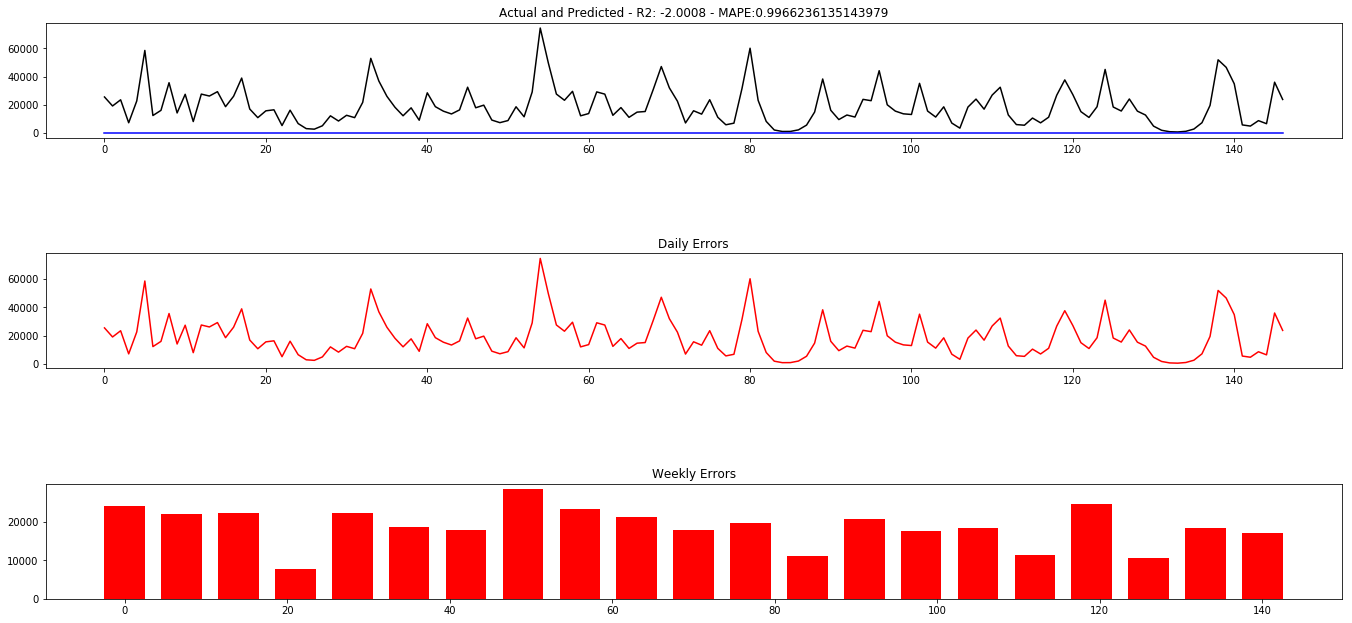

In [77]:
plot_prediction(Y_val_, model.predict(X_val_))

# Test Non-Normalized Model

In [78]:
X_test_ = test_data_dict[w]['X']
Y_test_ = test_data_dict[w]['Y']

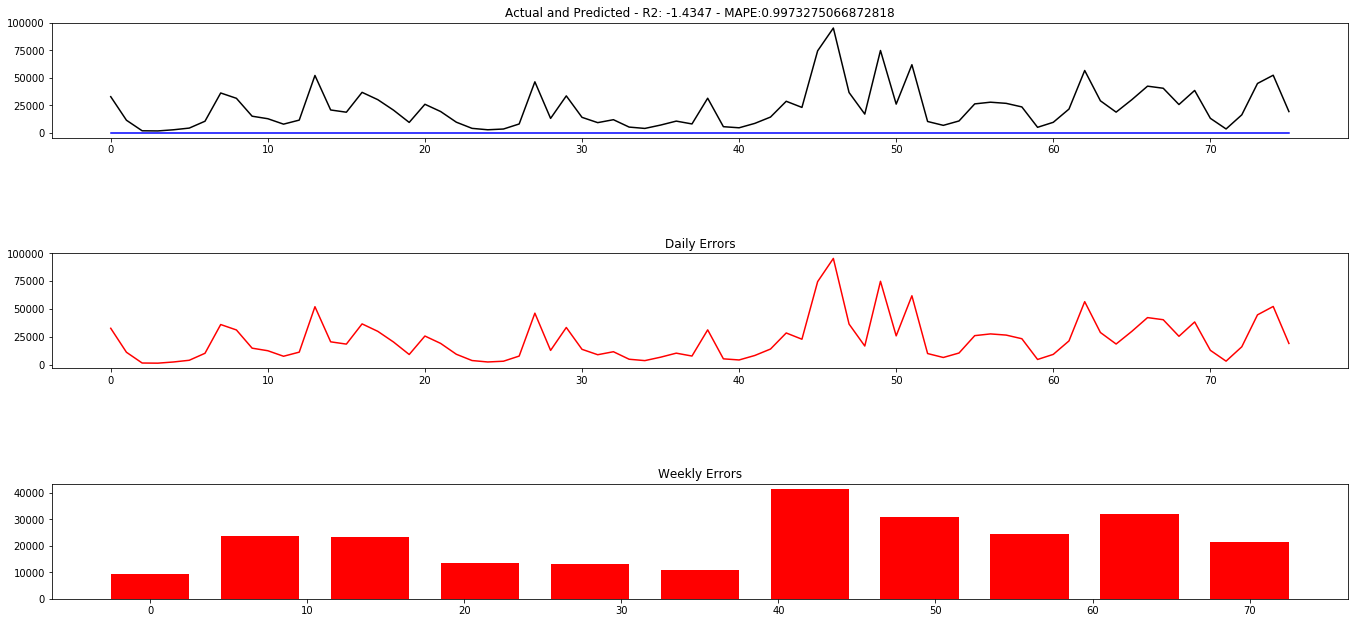

In [79]:
pred_y_ = model.predict(X_test_)
plot_prediction(Y_test_, pred_y_)

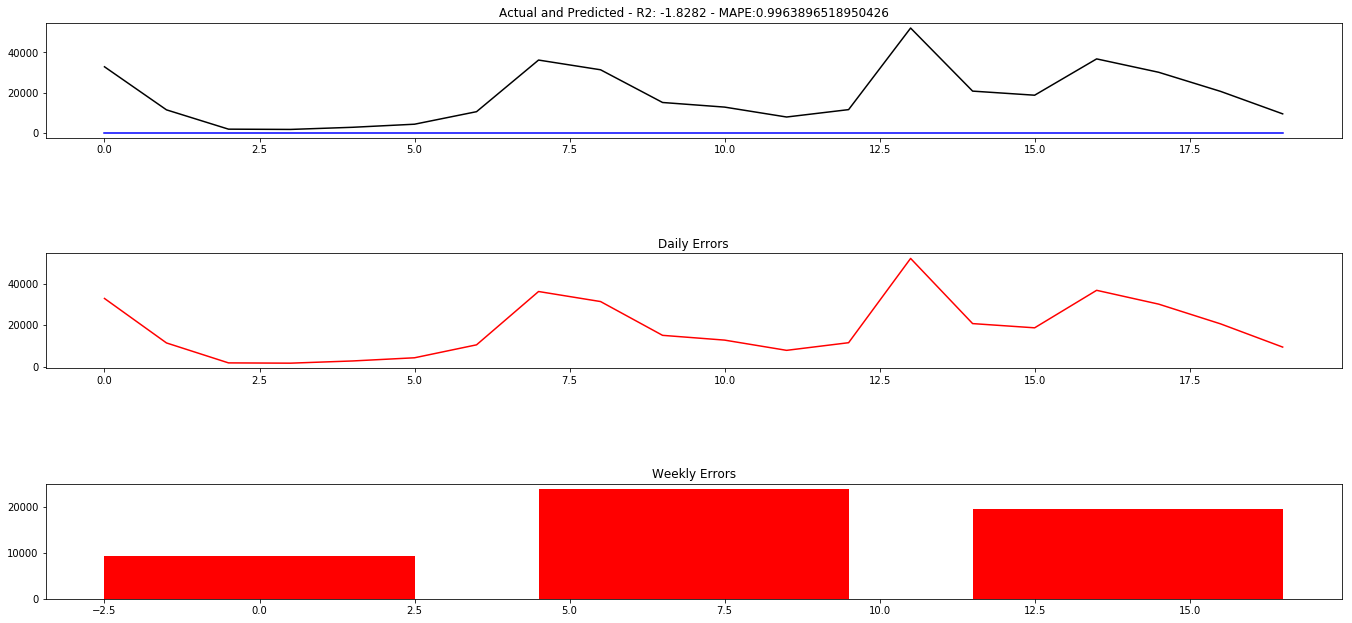

In [80]:
t=0
tp = 20
plot_prediction(Y_test_[t:t+tp], pred_y_[t:t+tp])